In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
sns.set(style="white", font_scale=2)

In [27]:
def rename_column(column_name):
    if column_name == 'liqe-resize':
        return 'LIQE'
    if column_name == 'maniqa-resize':
        return 'MANIQA'
    if column_name == 'artifact-padding':
        return 'Artifact Scorer'
    return column_name

In [28]:
def npz_to_dataframe(directory, img_directory=None):
    # Lists to store data
    records = []

    # Walk through all files in the directory
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            # Check if the file is an .npz file
            if filename in ['in_dist_prompts-image-scores.npz', 'image-scores.npz']:
                filepath = os.path.join(dirpath, filename)

                # Load npz file
                with np.load(filepath) as data:
                    arrays = []
                    for key in data.keys():
                        if 'artifact' in key:
                            arrays.append(5 - data[key])
                        else:
                            arrays.append(data[key])
                    if arrays:
                        stacked = np.vstack(arrays).T

                        if img_directory is not None:
                            # Get corresponding images for the npz
                            corresponding_img_dir = os.path.join(
                                img_directory,
                                os.path.relpath(dirpath, directory))
                            all_images = [
                                img
                                for img in os.listdir(corresponding_img_dir)
                                if img.endswith(('.jpg', '.jpeg', '.png',
                                                 '.webp'))
                            ]
                            sorted_images = sorted(
                                all_images, key=lambda x: os.path.basename(x))

                            if len(stacked) != len(sorted_images):
                                raise ValueError(
                                    f"Number of images in {corresponding_img_dir} doesn't match stacked array length for {filepath}"
                                )

                        for i in range(stacked.shape[0]):
                            record = {
                                'folder_path':
                                os.path.relpath(filepath, directory)
                            }
                            if img_directory is not None:
                                record['image_path'] = sorted_images[i]
                            for j, key in enumerate(data.keys()):
                                record[key] = stacked[i, j]
                            records.append(record)

    # Construct a DataFrame
    df = pd.DataFrame(records)
    df['category'] = df['folder_path'].apply(lambda x: x.split(os.path.sep)[0])
    df['class'] = df['folder_path'].apply(lambda x: '-'.join(x.split(os.path.sep)[:-1]))
    if 'artifact-resize' in df.columns:
        df = df.drop(columns='artifact-resize')
    df.columns = df.columns.map(rename_column)

    return df

### Dataset

In [29]:
df = npz_to_dataframe(
    '/media/sashi/DATA1/datasets_downloaded/lycoris_exp_paper/image_quality_scores/ref_scores/',
    '/media/sashi/DATA1/datasets_downloaded/lycoris_exp_paper/dataset/evaluation'
)

In [30]:
df

,folder_path,image_path,LIQE,MANIQA,Artifact Scorer,category,class
0,anime/abukuma/none/image-scores.npz,1741730-0000.png,2.958466,0.497843,1.062500,anime,anime-abukuma-none
1,anime/abukuma/none/image-scores.npz,1880435-0000.png,2.875680,0.341723,1.132812,anime,anime-abukuma-none
2,anime/abukuma/none/image-scores.npz,1880758-0000.png,2.912888,0.504805,0.859375,anime,anime-abukuma-none
3,anime/abukuma/none/image-scores.npz,2043610-0000.png,2.955125,0.458454,1.804688,anime,anime-abukuma-none
4,anime/abukuma/none/image-scores.npz,2047729-0000.png,2.731260,0.495296,1.505859,anime,anime-abukuma-none
...,...,...,...,...,...,...,...
1691,style/vladimir_borovikovsky/image-scores.npz,vladimir-borovikovsky_portrait-of-yuri-f-lisya...,2.831093,0.404744,2.931641,style,style-vladimir_borovikovsky
1692,style/vladimir_borovikovsky/image-scores.npz,vladimir-borovikovsky_praskovia-bestuzhev-1806...,2.503381,0.355021,2.794922,style,style-vladimir_borovikovsky
1693,style/vladimir_borovikovsky/image-scores.npz,vladimir-borovikovsky_princess-lopukhina.jpg,3.009613,0.446150,2.667969,style,style-vladimir_borovikovsky
1694,style/vladimir_borovikovsky/image-scores.npz,vladimir-borovikovsky_rodzianko-ekaterina.jpg,3.043759,0.468877,2.390625,style,style-vladimir_borovikovsky


In [15]:
df.sort_values(by='LIQE')[:50][['image_path']]

,image_path
601,image_20211118_162049.jpg
1332,alfred-sisley_snow-at-marly-le-roi-1876.jpg
1380,walter-sickert_off-to-the-pub.jpg
666,image_20211118_162141_1724.jpg
1409,william-merritt-chase_the-japanese-book-1900.jpg
1006,felix-vallotton_portrait-of-french-writer-vict...
988,felix-vallotton_portrait-of-french-writer-henr...
1000,felix-vallotton_portrait-of-french-writer-paul...
1488,image_258.jpg
1002,felix-vallotton_portrait-of-french-writer-ren-...


In [16]:
df.sort_values(by='Artifact')[-50:][['image_path']]

,image_path
1486,image_256.jpg
797,image_20211118_161933.jpg
864,ravi-pinisetti-sxWyOaHJb0s-unsplash.jpg
963,felix-vallotton_portrait-of-french-poet-jehan-...
974,felix-vallotton_portrait-of-french-writer-and-...
865,tim-mossholder-o3qMftQupG8-unsplash.jpg
1002,felix-vallotton_portrait-of-french-writer-ren-...
1348,robert-julian-onderdonk_landscape-4.jpg
1646,vladimir-borovikovsky_portrait-of-aleksei-alek...
1364,rudolf-schweitzer-cumpana_peisaj-de-iarn.jpg


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


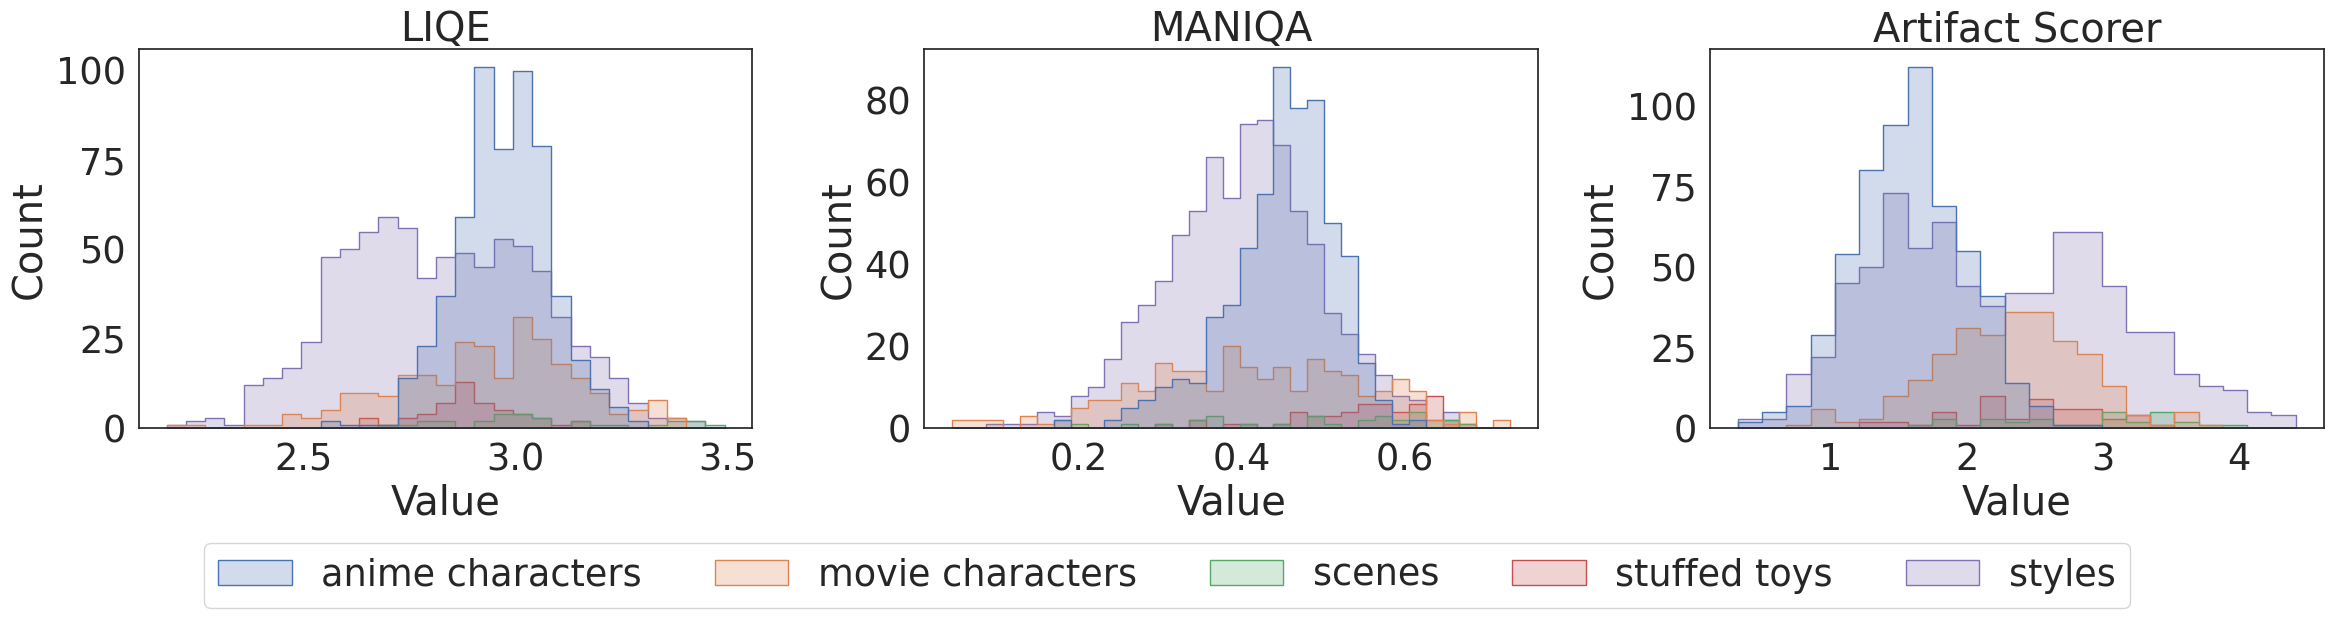

In [63]:
df['dummy_index'] = range(len(df))
metrics = df.columns[2:5]

sns.set(style="white", font_scale=2.4)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_df = df.pivot(index='dummy_index',
                         columns='category',
                         values=metric)
    sns.histplot(data=metric_df, element="step", common_norm=False, ax=ax)

    legend = ax.get_legend()
    handles = legend.legendHandles

    ax.set_title(f'{metric}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend().remove()  # Remove individual legends

fig = plt.gcf()
fig.legend(handles=handles,
           labels=[
               'anime characters', 'movie characters', 'scenes',
               'stuffed toys', 'styles'
           ],
           loc='lower center',
           bbox_to_anchor=(0.5, -0.1),
           ncol=len(handles))
plt.tight_layout()
plt.savefig(f'figures/dataset-IMQ.png', bbox_inches='tight', pad_inches=0.1)

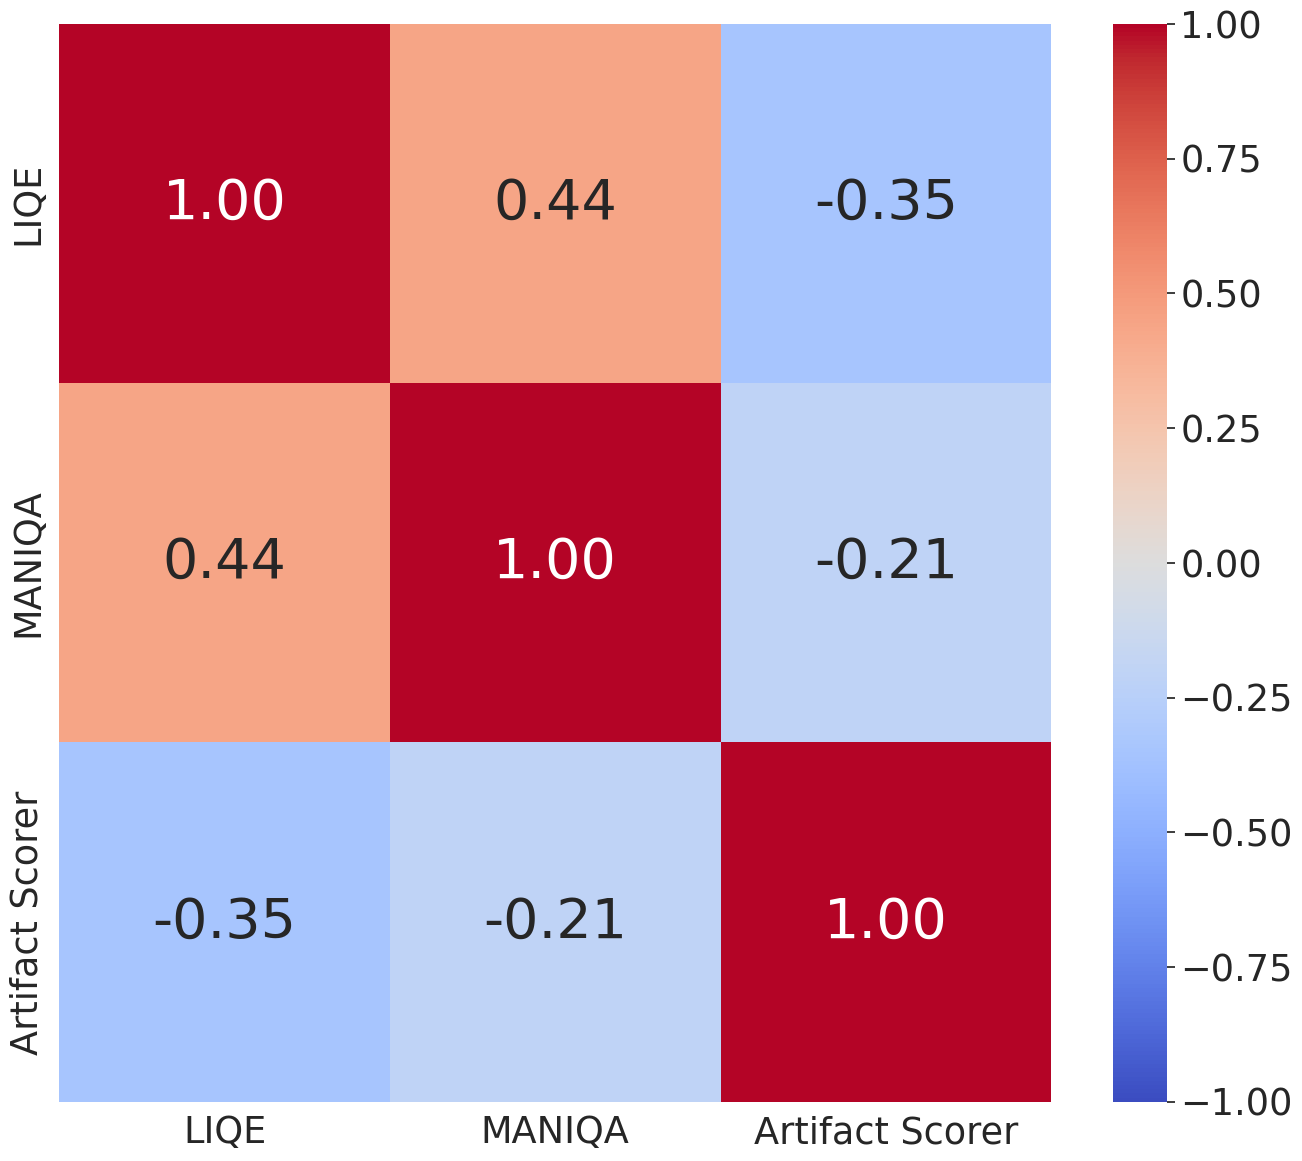

In [68]:
ordered_cols = ['LIQE', 'MANIQA', 'Artifact Scorer']
correlation_matrix = df[ordered_cols].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt=".2f",
            annot_kws={"size": 40})
plt.savefig(f'figures/dataset-corr.png', bbox_inches='tight', pad_inches=0.1)

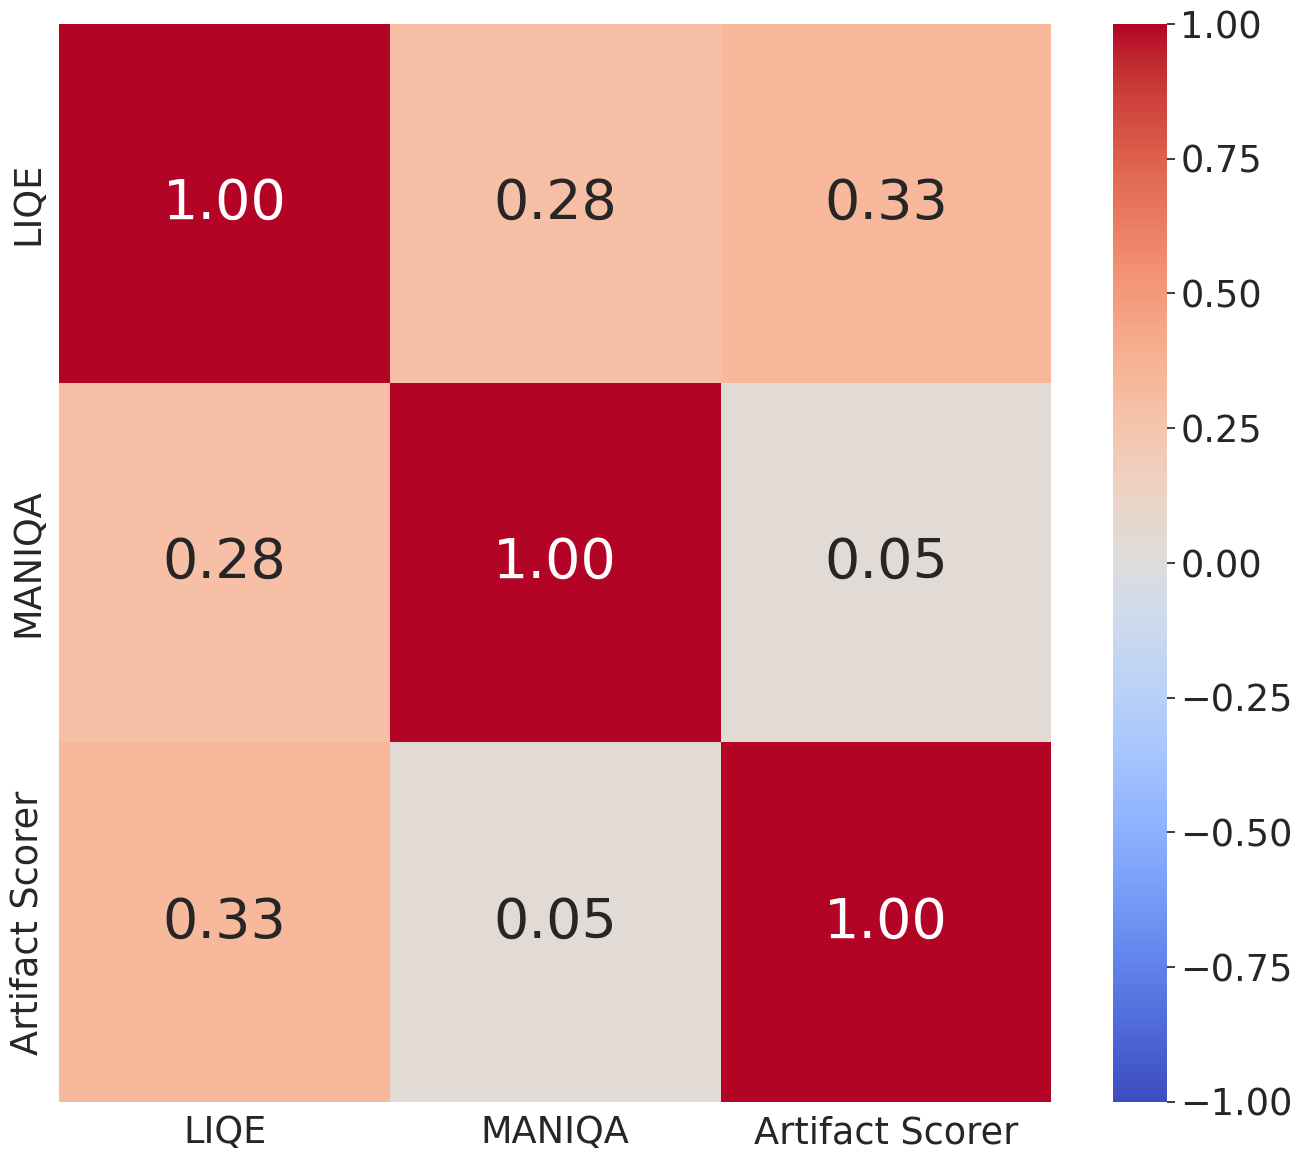

In [69]:
ordered_cols = ['LIQE', 'MANIQA', 'Artifact Scorer']
df_sel = df[df['category'].apply(lambda x: x not in ['anime', 'style'])]
correlation_matrix = df_sel[ordered_cols].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt=".2f",
            annot_kws={"size": 40})
plt.savefig(f'figures/dataset-corr-photorealistic.png', bbox_inches='tight', pad_inches=0.1)

### Generated images

In [70]:
dir_name = 'ddim-v1-5-pruned-emaonly-exp-1001-sd15-lora8a4-a-000010'
config_name = 'lora-10-paper'
save_dir = os.path.join('figures', config_name)
os.makedirs(save_dir, exist_ok=True)

In [71]:
df_gen = npz_to_dataframe(
    '/media/sashi/DATA1/datasets_downloaded/lycoris_exp_paper/image_quality_scores/' + dir_name,
    None
)

In [72]:
df_gen

,folder_path,LIQE,MANIQA,Artifact Scorer,category,class
0,anime/abukuma/none/in_dist_prompts-image-score...,2.851718,0.523662,1.400391,anime,anime-abukuma-none
1,anime/abukuma/none/in_dist_prompts-image-score...,2.880303,0.494578,1.230469,anime,anime-abukuma-none
2,anime/abukuma/none/in_dist_prompts-image-score...,2.984672,0.490404,1.535156,anime,anime-abukuma-none
3,anime/abukuma/none/in_dist_prompts-image-score...,3.011574,0.446018,1.361328,anime,anime-abukuma-none
4,anime/abukuma/none/in_dist_prompts-image-score...,3.051420,0.578875,1.552734,anime,anime-abukuma-none
...,...,...,...,...,...,...
3895,style/vladimir_borovikovsky/in_dist_prompts-im...,2.737362,0.514081,1.455078,style,style-vladimir_borovikovsky
3896,style/vladimir_borovikovsky/in_dist_prompts-im...,2.772402,0.438669,2.611328,style,style-vladimir_borovikovsky
3897,style/vladimir_borovikovsky/in_dist_prompts-im...,2.657936,0.279994,2.628906,style,style-vladimir_borovikovsky
3898,style/vladimir_borovikovsky/in_dist_prompts-im...,2.976469,0.663464,2.531250,style,style-vladimir_borovikovsky


In [30]:
df_gen.columns[1:5]

Index(['liqe-resize', 'maniqa-resize', 'artifact-padding', 'category'], dtype='object')

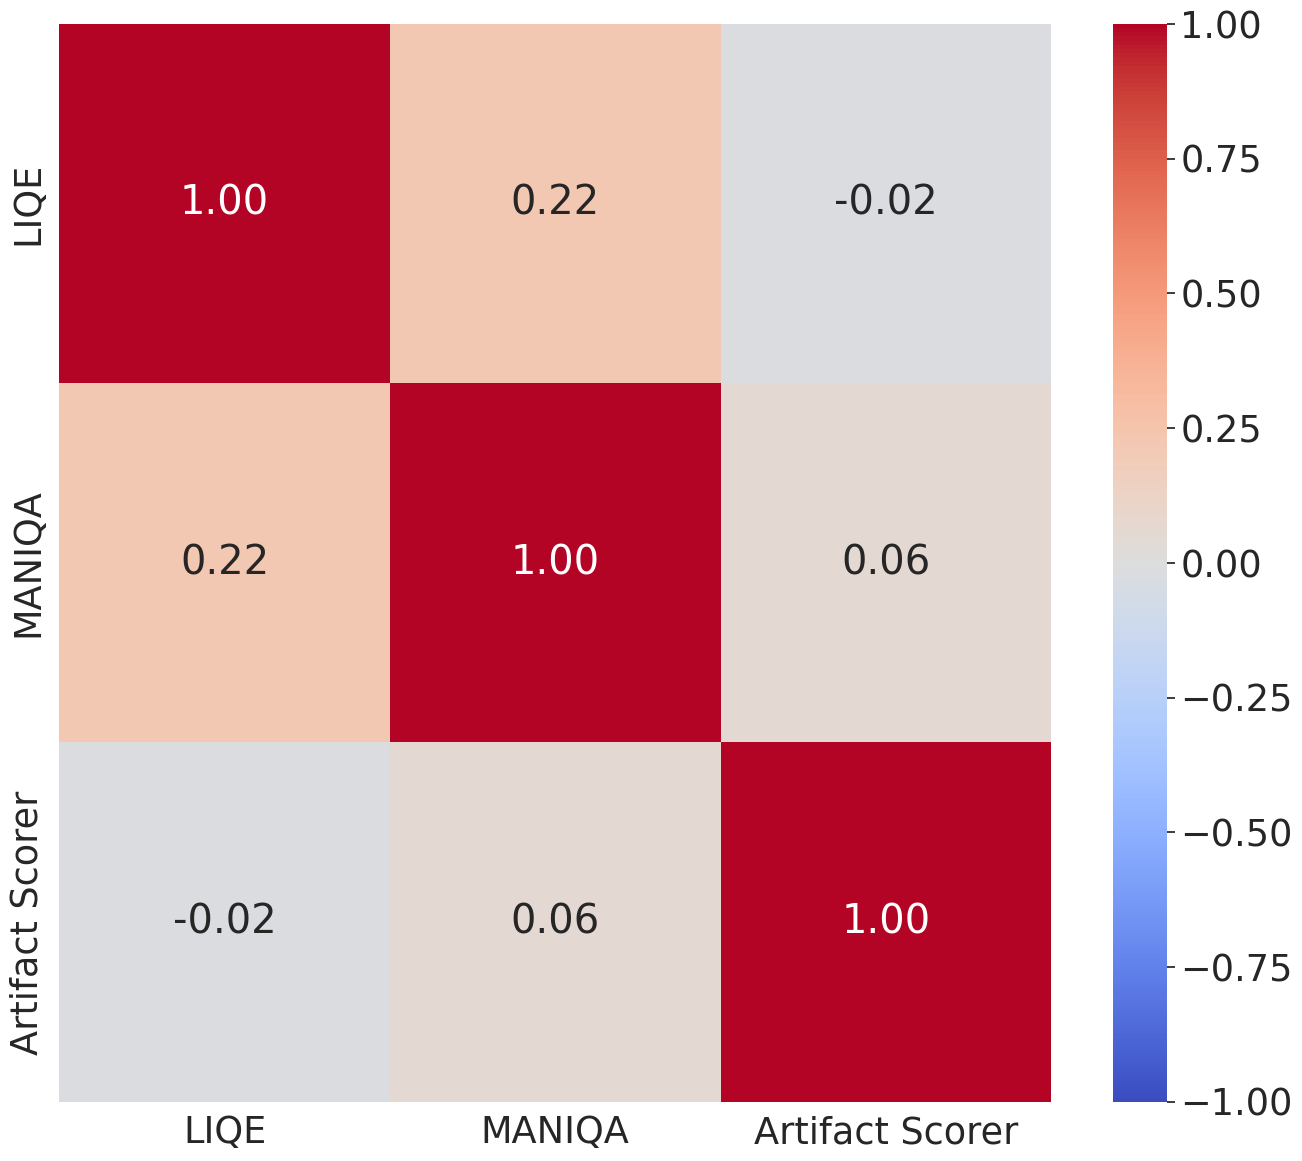

In [95]:
sns.set(style="white", font_scale=2.4)
ordered_cols = ['LIQE', 'MANIQA', 'Artifact Scorer']

correlation_matrix = df_gen[ordered_cols].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt=".2f")
plt.savefig(f'figures/generated-corr.png', bbox_inches='tight', pad_inches=0.1)

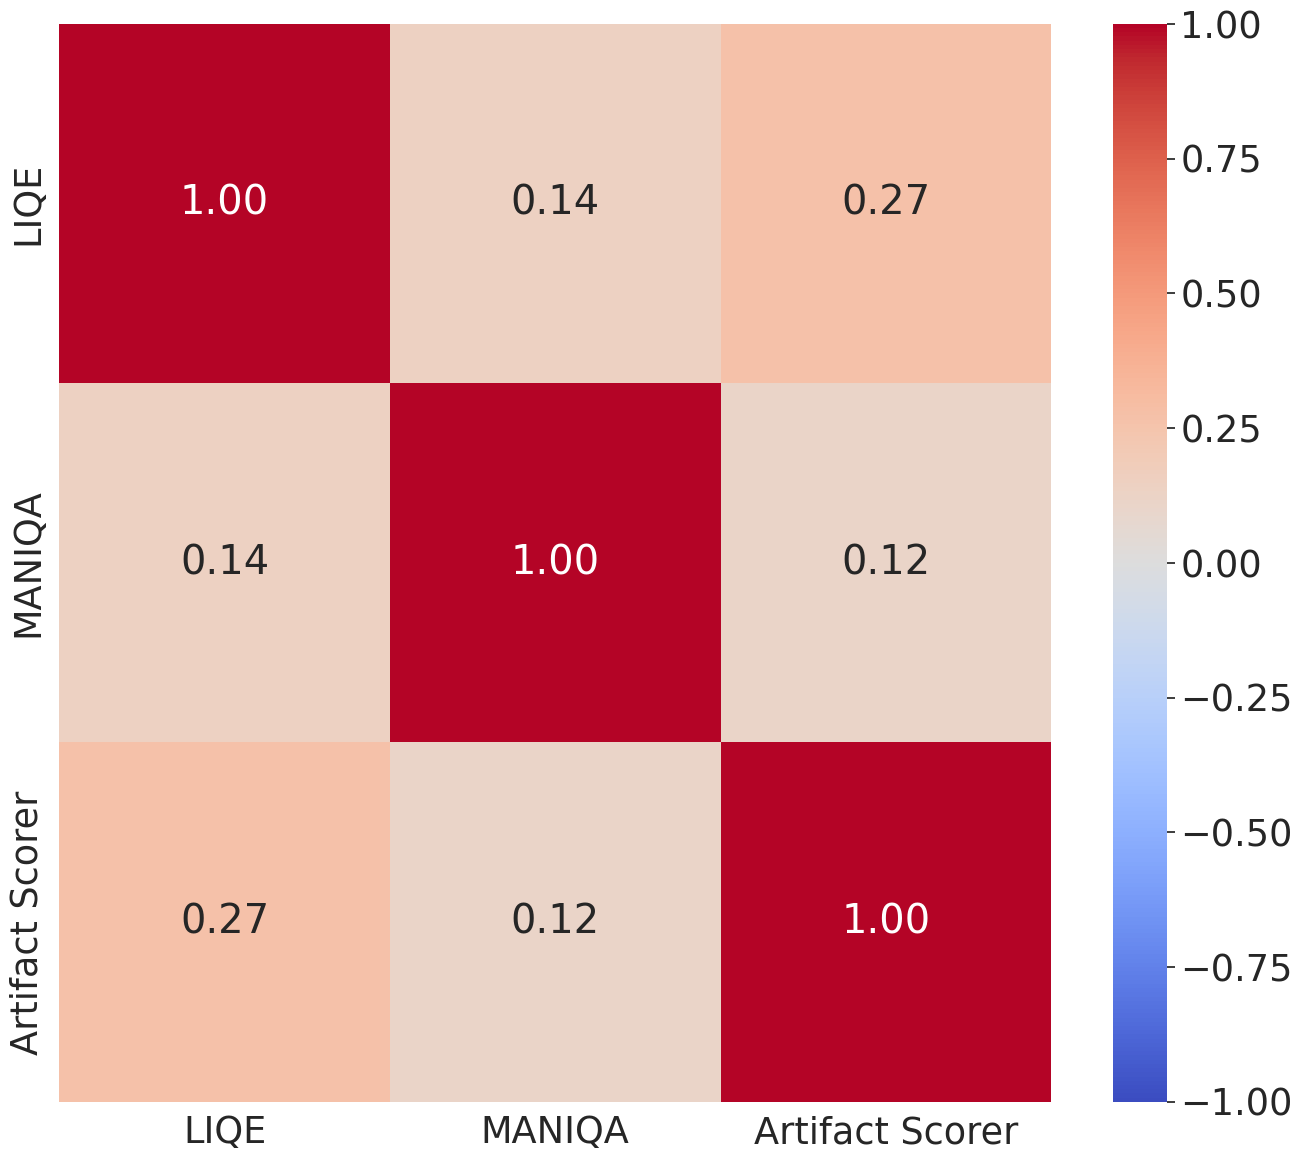

In [96]:
ordered_cols = ['LIQE', 'MANIQA', 'Artifact Scorer']

df_gen_sel = df_gen[df_gen['category'].apply(
    lambda x: x not in ['anime', 'style'])]
correlation_matrix = df_gen_sel[ordered_cols].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt=".2f")
plt.savefig(f'figures/generated-corr-photorealistic.png', bbox_inches='tight', pad_inches=0.1)

In [21]:
def plot_mirrored_histogram(df1, df2, metric):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 10))

    # Stack the dataframes with an indicator column
    df1['source'] = 'df1'
    df2['source'] = 'df2'
    combined = pd.concat([df1, df2])

    sns.histplot(data=combined[combined['source'] == 'df1'],
                 x=metric,
                 hue='category',
                 element="step",
                 ax=axes[0])
    sns.histplot(data=combined[combined['source'] == 'df2'],
                 x=metric,
                 hue='category',
                 element="step",
                 ax=axes[1])

    axes[1].invert_yaxis()

    plt.subplots_adjust(hspace=0)
    plt.title(f'Metric: {metric}, real on top, fake at bottom')
    plt.xlabel('Value')
    plt.tight_layout()

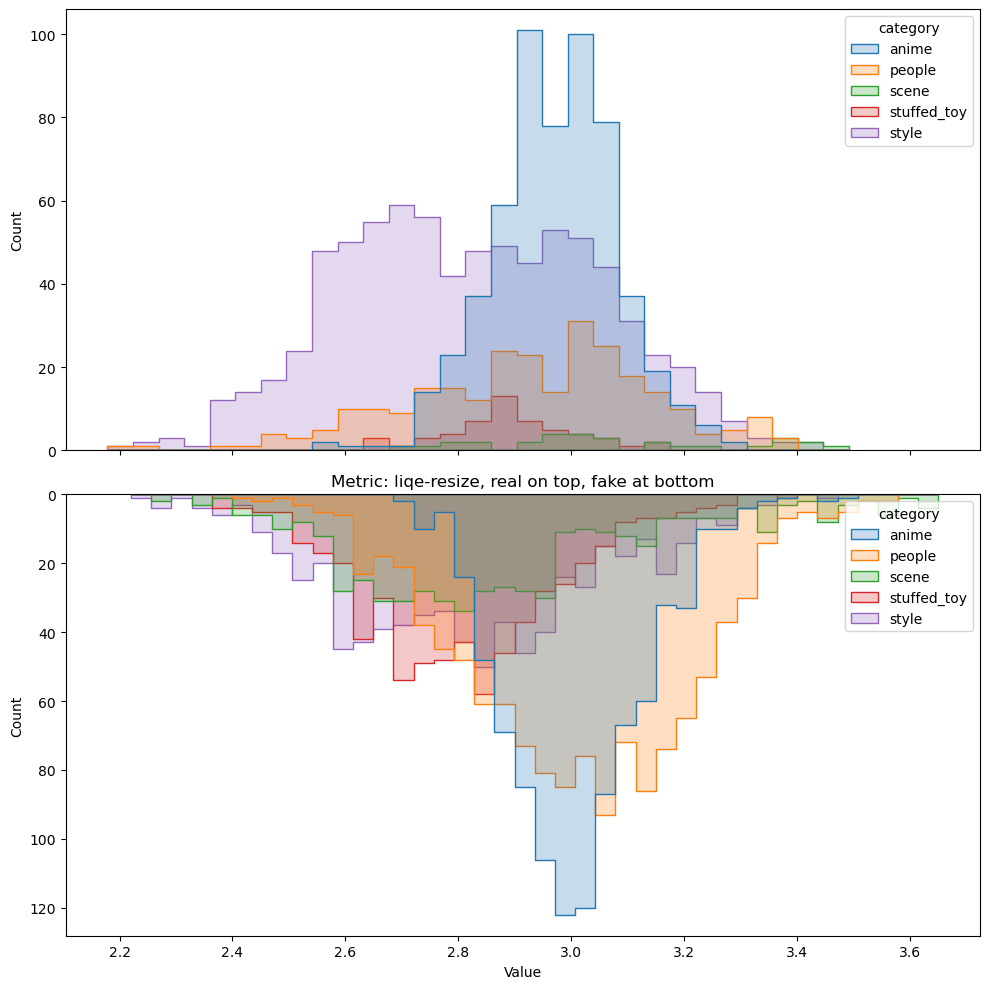

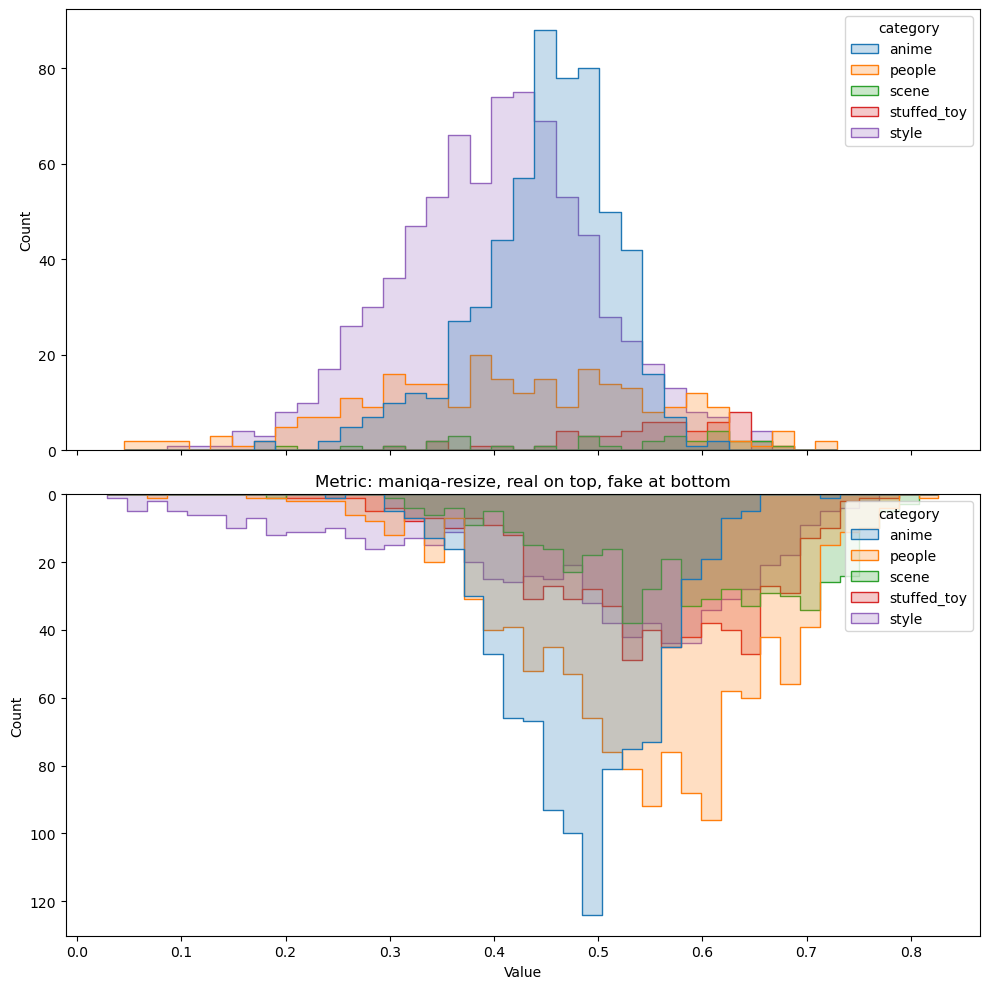

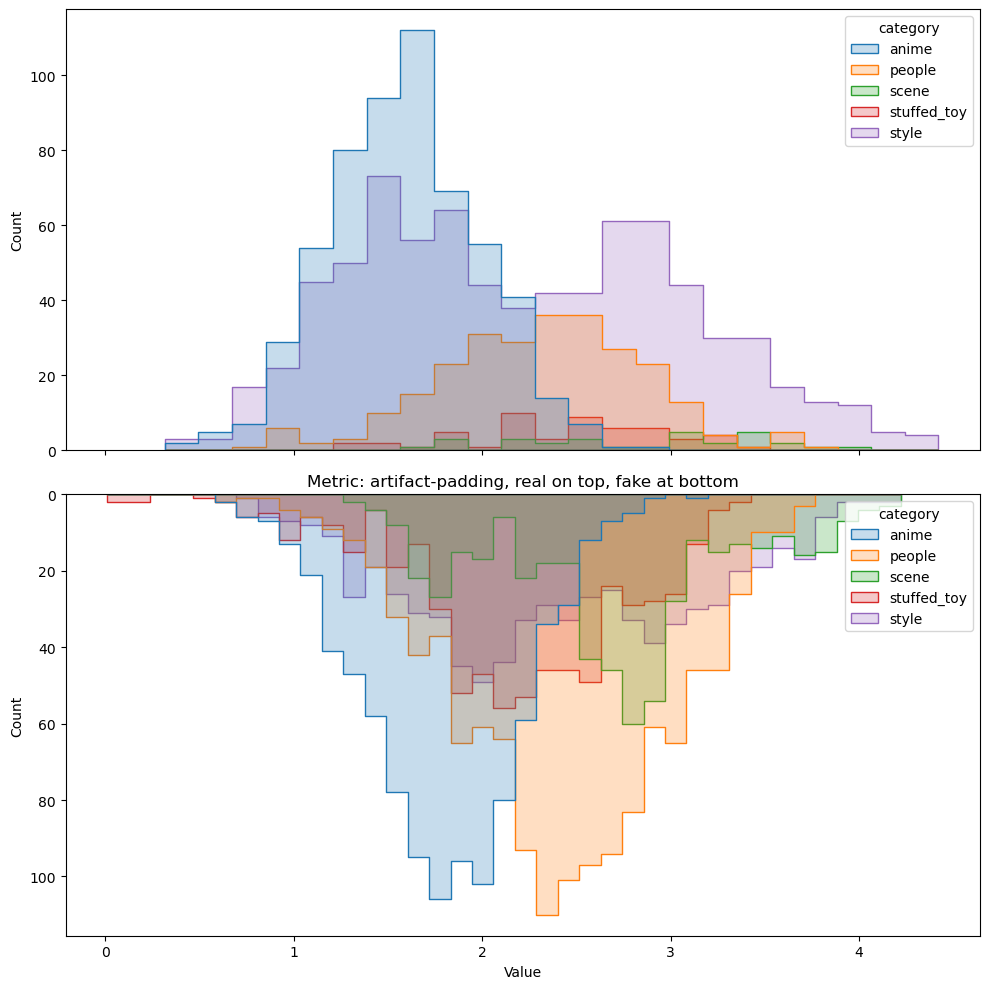

In [33]:
metrics = df_gen.columns[1:4]

for metric in metrics:
    plot_mirrored_histogram(df, df_gen, metric)
    plt.savefig(f'{save_dir}/{config_name}-{metric}.png')

In [114]:
df_gen.columns[1:4]

Index(['liqe-resize', 'maniqa-resize', 'artifact-padding'], dtype='object')

In [92]:
category_names = {
    'anime': 'anime characters',
    'people': 'movie characters',
    'scene': 'scenes',
    'stuffed_toy': 'stuffed toys',
    'style': 'styles',
}

In [93]:
def plot_mirrored_histogram_category(df1, df2, metric, cat_name, cat='category'):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 6))

    sns.histplot(data=df1[df1[cat] == cat_name],
                 x=metric,
                 element="step",
                 ax=axes[0],
                 color='blue',
                 label='df1')
    axes[0].set_ylabel('')
    sns.histplot(data=df2[df2[cat] == cat_name],
                 x=metric,
                 element="step",
                 ax=axes[1],
                 color='orange',
                 label='df2')
    plt.ylabel('')
    plt.xlabel('')

    axes[1].invert_yaxis()

    plt.subplots_adjust(hspace=-10) 
    # plt.title(f'Metric: {metric} for Category: {cat_name}')
    plt.xlabel(category_names[cat_name])
    plt.tight_layout()

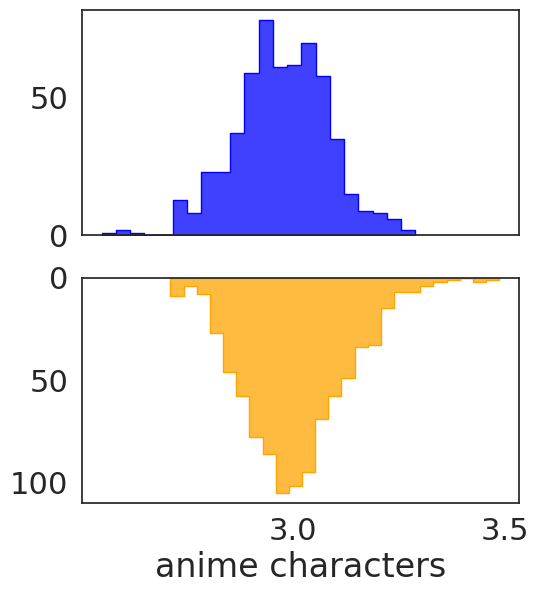

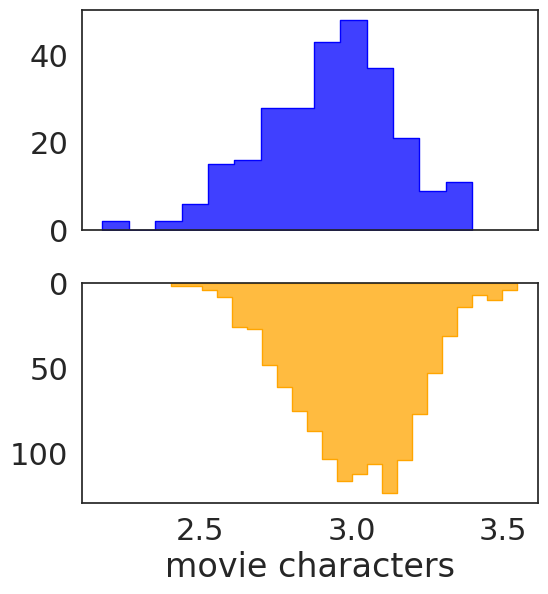

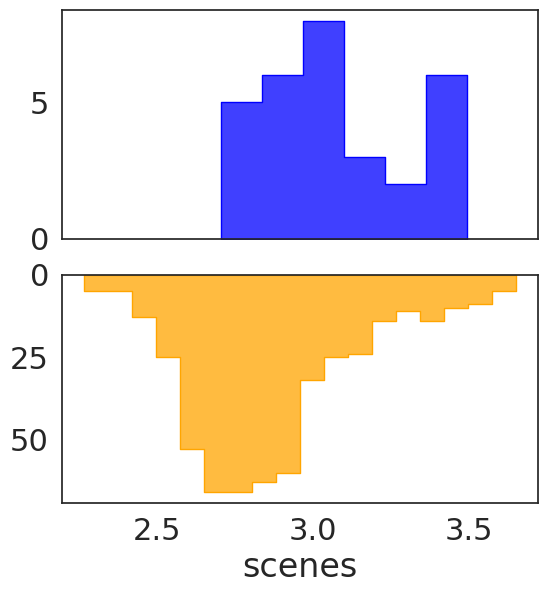

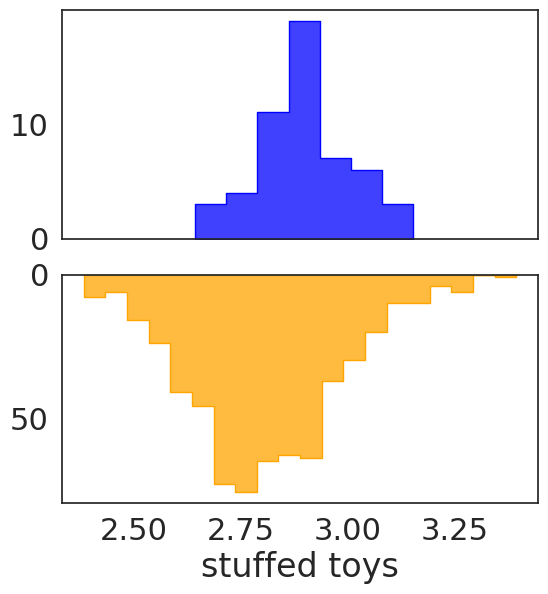

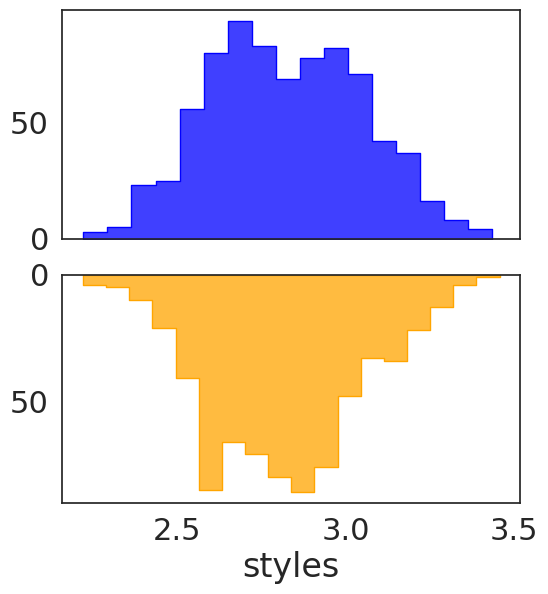

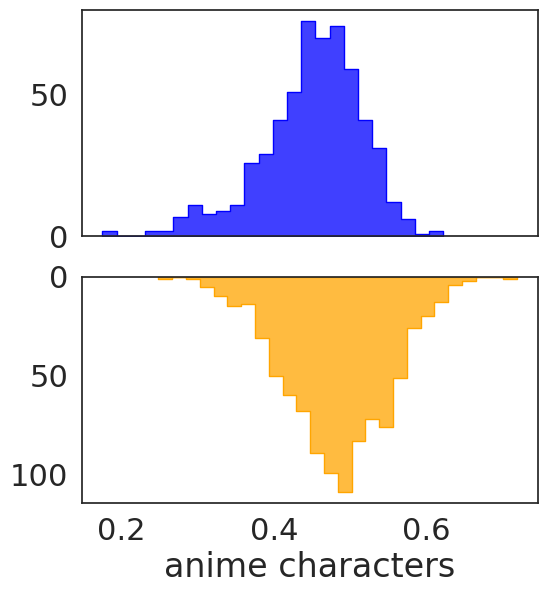

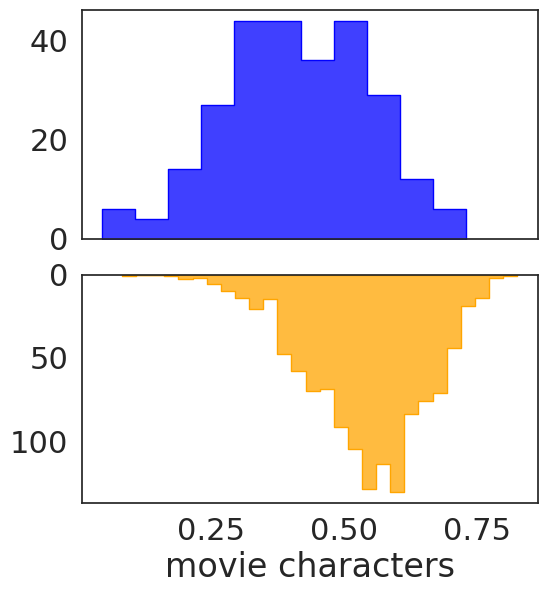

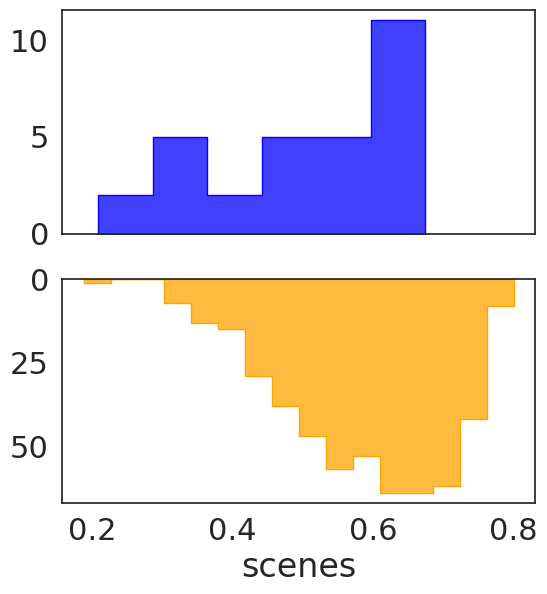

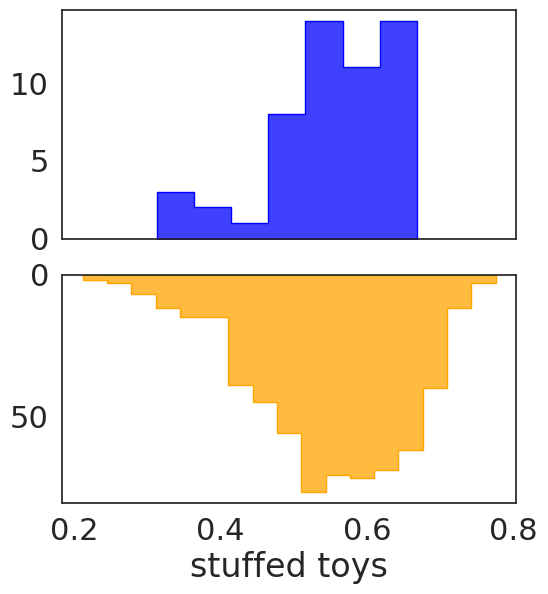

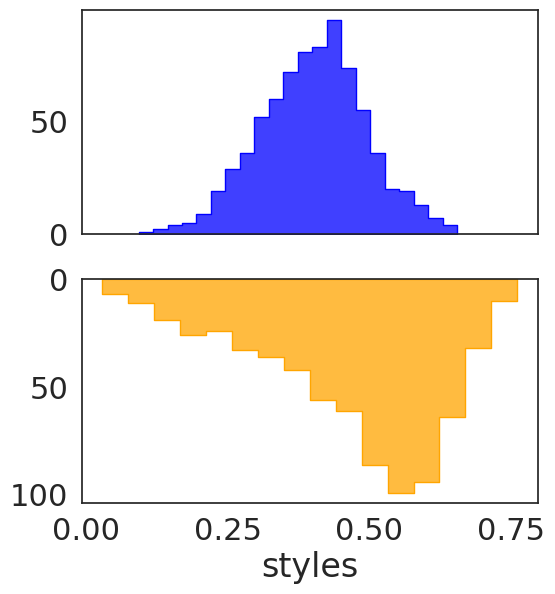

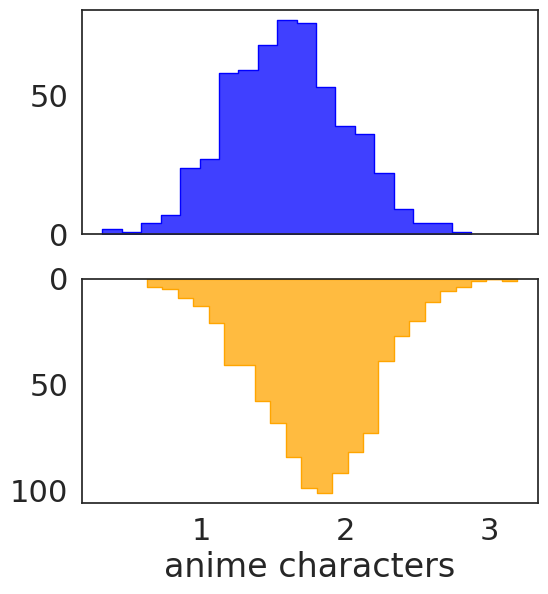

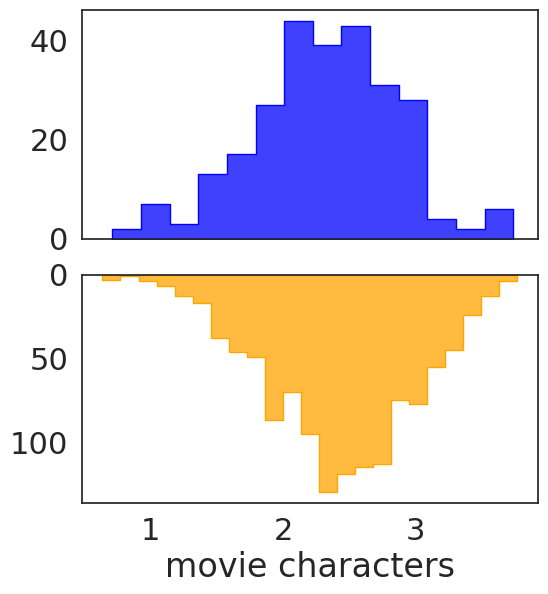

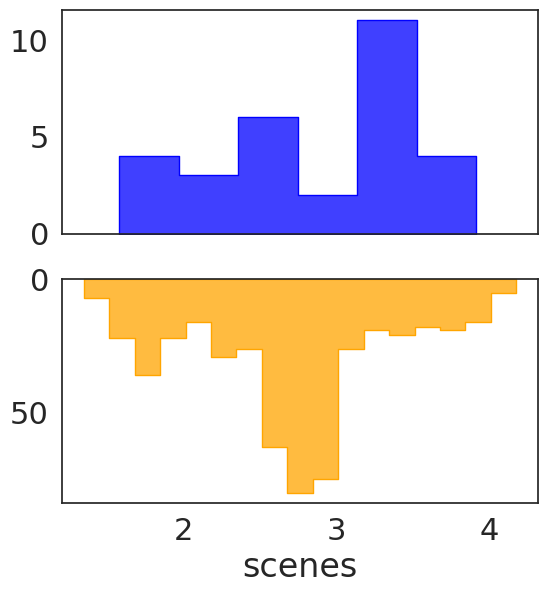

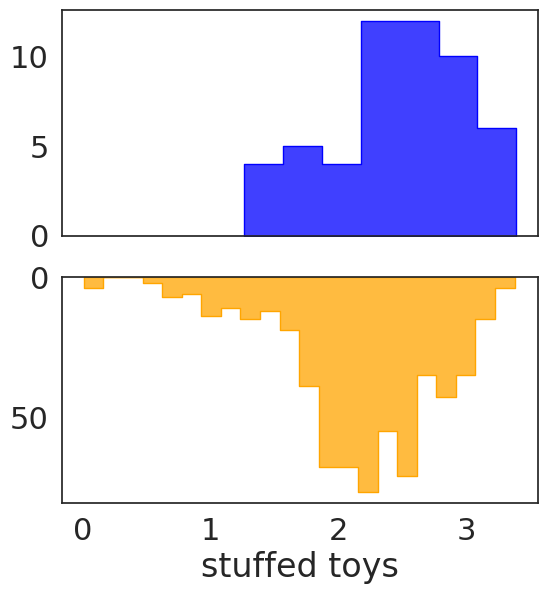

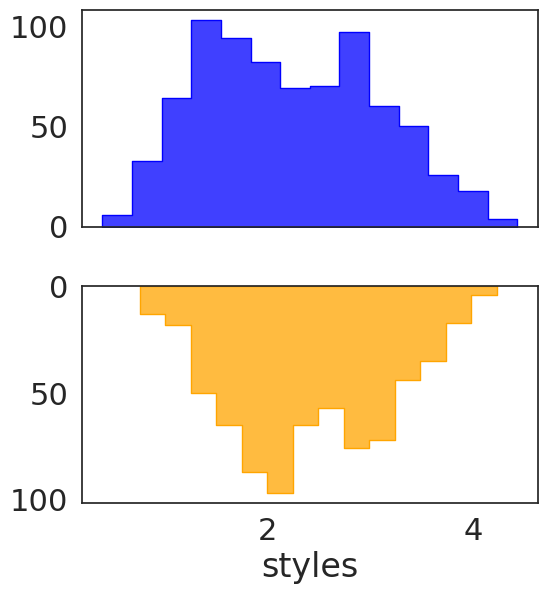

In [94]:
sns.set(style="white", font_scale=2)
metrics = df_gen.columns[1:4]
categories = df_gen['category'].unique()

for metric in metrics:
    for category in categories:
        plot_mirrored_histogram_category(df, df_gen, metric, category)
        plt.savefig(f'{save_dir}/{config_name}-{metric}-{category}.png',
                    bbox_inches='tight',
                    pad_inches=0.1)

In [40]:
metrics = df_gen.columns[1:4]
categories = df_gen['class'].unique()
os.makedirs(os.path.join(save_dir, 'classes'), exist_ok=True)

for metric in metrics:
    for cls in categories:
        plot_mirrored_histogram_category(df, df_gen, metric, cls, cat='class')
        plt.savefig(f'{save_dir}/classes/{config_name}-{metric}-{cls}.png')
        plt.close()

### Generated images 2

In [54]:
dir_name = 'ddim-v1-5-pruned-emaonly-exp-1022-sd15-lokrf4-a-000010'
config_name = 'lokrf4-10'
save_dir = os.path.join('figures', config_name)
os.makedirs(save_dir, exist_ok=True)

In [55]:
df_gen_lokr = npz_to_dataframe(
    '/media/sashi/DATA1/datasets_downloaded/lycoris_exp_paper/image_quality_scores/' + dir_name,
    None
)

In [56]:
df_gen_lokr

,folder_path,artifact-padding,liqe-resize,maniqa-resize,category,class
0,anime/abukuma/none/in_dist_prompts-image-score...,1.234375,2.880357,0.443448,anime,anime-abukuma-none
1,anime/abukuma/none/in_dist_prompts-image-score...,0.878906,2.860538,0.459007,anime,anime-abukuma-none
2,anime/abukuma/none/in_dist_prompts-image-score...,1.251953,2.959270,0.423894,anime,anime-abukuma-none
3,anime/abukuma/none/in_dist_prompts-image-score...,0.390625,2.805430,0.452306,anime,anime-abukuma-none
4,anime/abukuma/none/in_dist_prompts-image-score...,1.468750,2.988910,0.455932,anime,anime-abukuma-none
...,...,...,...,...,...,...
3895,style/vladimir_borovikovsky/in_dist_prompts-im...,1.285156,2.893661,0.357054,style,style-vladimir_borovikovsky
3896,style/vladimir_borovikovsky/in_dist_prompts-im...,1.142578,2.645811,0.384519,style,style-vladimir_borovikovsky
3897,style/vladimir_borovikovsky/in_dist_prompts-im...,1.521484,2.727709,0.406662,style,style-vladimir_borovikovsky
3898,style/vladimir_borovikovsky/in_dist_prompts-im...,1.527344,3.056584,0.335412,style,style-vladimir_borovikovsky


In [44]:
df_gen_lokr.columns[1:5]

Index(['artifact-padding', 'liqe-resize', 'maniqa-resize', 'category'], dtype='object')

<AxesSubplot: >

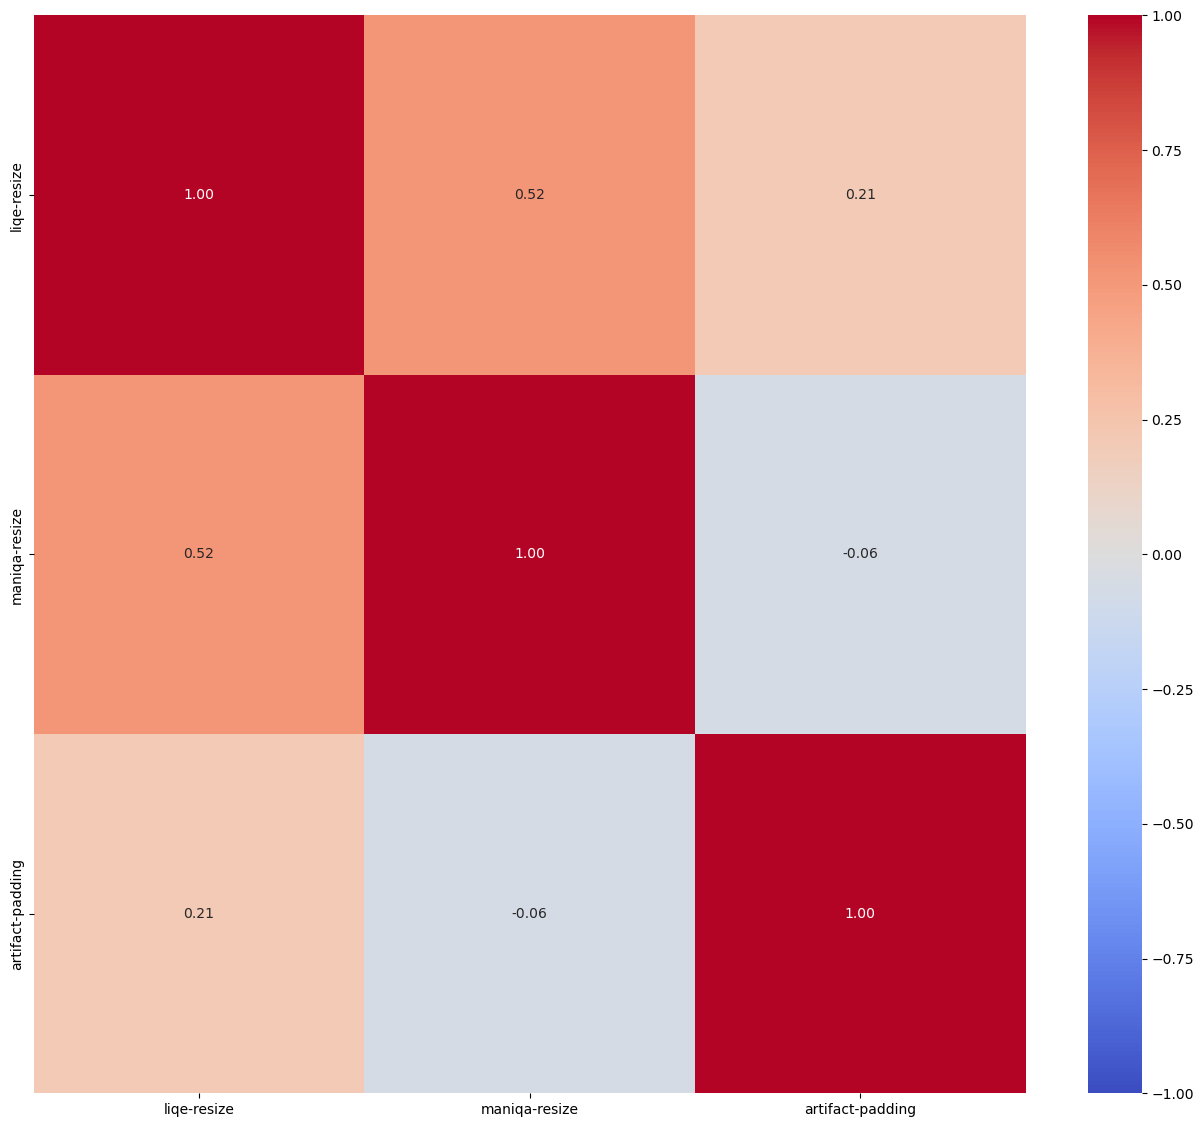

In [45]:
ordered_cols = ['liqe-resize', 'maniqa-resize', 'artifact-padding']
correlation_matrix = df_gen[ordered_cols].corr()
df_gen_sel = df_gen_lokr[df_gen_lokr['category'].apply(
    lambda x: x not in ['anime', 'style'])]
correlation_matrix = df_gen_sel[ordered_cols].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt=".2f")

In [46]:
def plot_mirrored_histogram(df1, df2, metric):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 10))

    # Stack the dataframes with an indicator column
    df1['source'] = 'df1'
    df2['source'] = 'df2'
    combined = pd.concat([df1, df2])

    sns.histplot(data=combined[combined['source'] == 'df1'],
                 x=metric,
                 hue='category',
                 element="step",
                 ax=axes[0])
    sns.histplot(data=combined[combined['source'] == 'df2'],
                 x=metric,
                 hue='category',
                 element="step",
                 ax=axes[1])

    axes[1].invert_yaxis()

    plt.subplots_adjust(hspace=0)
    plt.title(f'Metric: {metric}, real on top, fake at bottom')
    plt.xlabel('Value')
    plt.tight_layout()

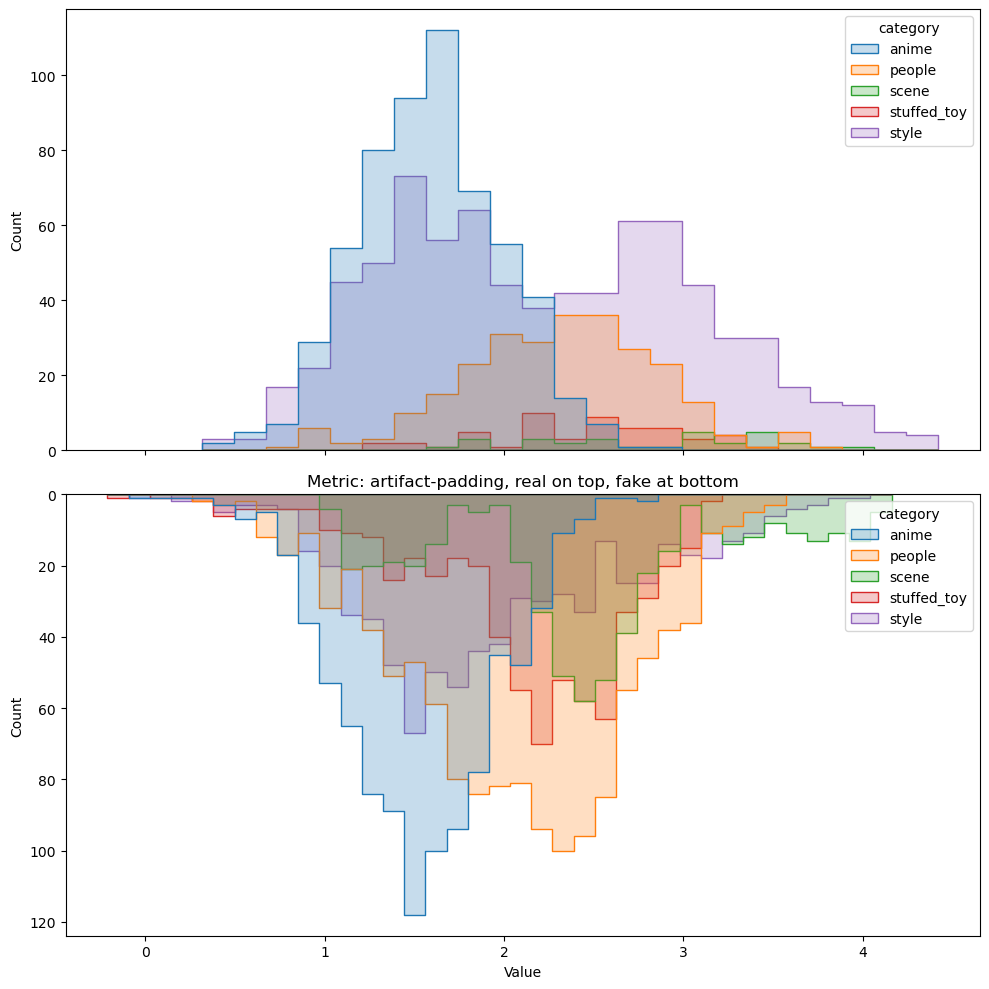

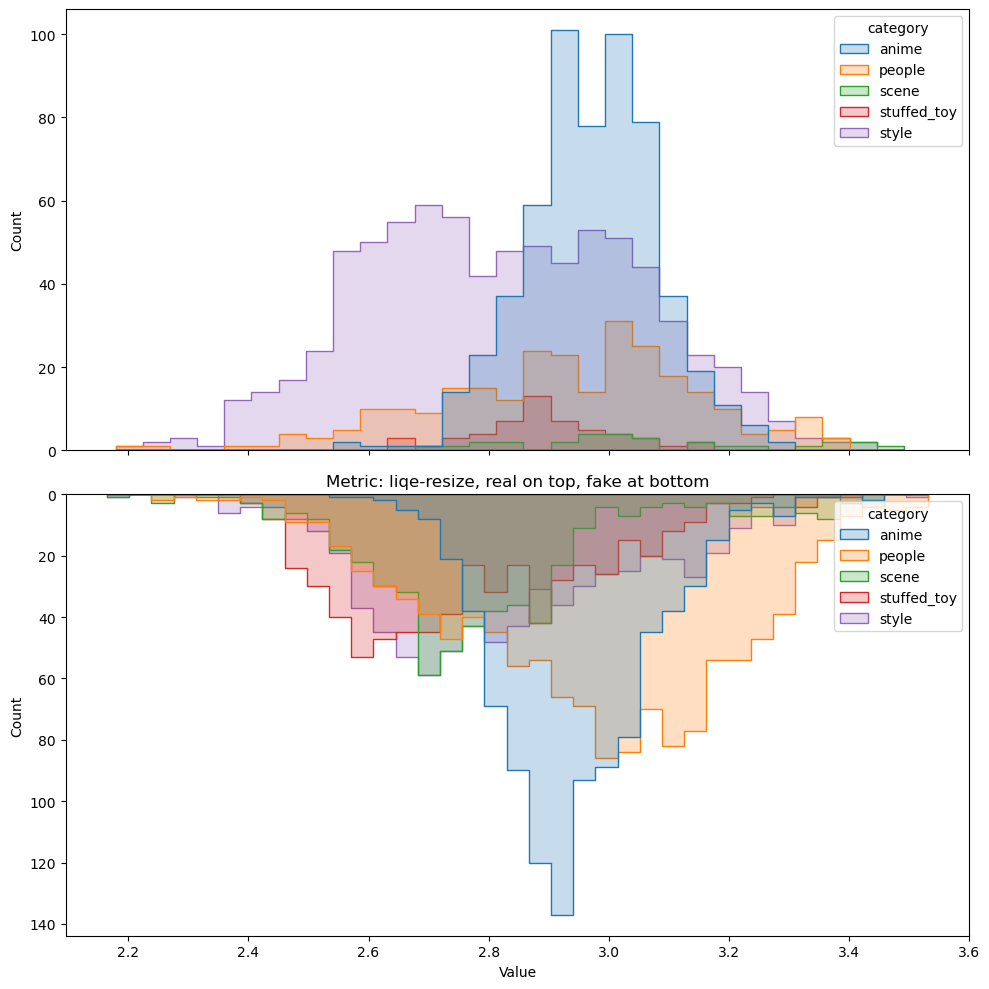

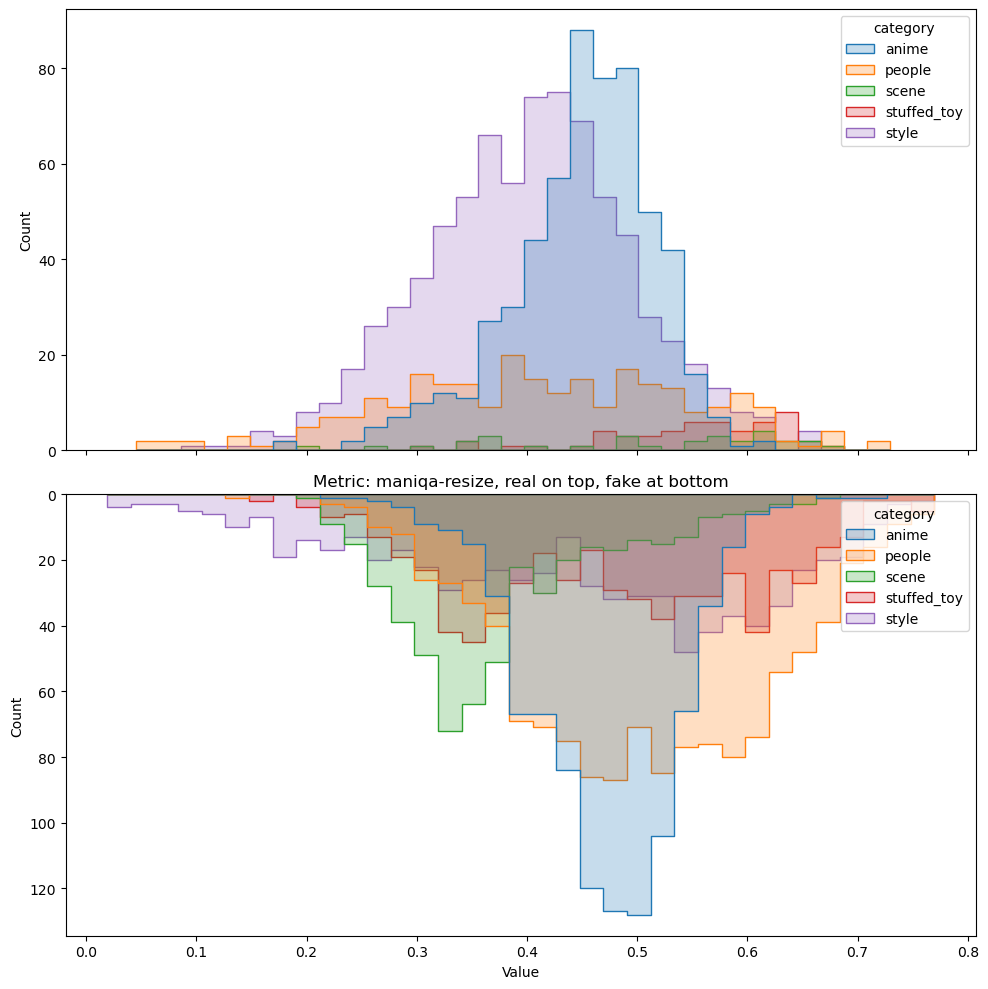

In [47]:
metrics = df_gen.columns[1:4]

for metric in metrics:
    plot_mirrored_histogram(df, df_gen_lokr, metric)
    plt.savefig(f'{save_dir}/{config_name}-{metric}.png')

In [48]:
df_gen.columns[1:4]

Index(['artifact-padding', 'liqe-resize', 'maniqa-resize'], dtype='object')

In [49]:
def plot_mirrored_histogram_category(df1, df2, metric, cat_name, cat='category'):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

    sns.histplot(data=df1[df1[cat] == cat_name],
                 x=metric,
                 element="step",
                 ax=axes[0],
                 color='blue',
                 label='df1')
    sns.histplot(data=df2[df2[cat] == cat_name],
                 x=metric,
                 element="step",
                 ax=axes[1],
                 color='orange',
                 label='df2')

    axes[1].invert_yaxis()

    plt.subplots_adjust(hspace=0)
    plt.title(f'Metric: {metric} for Category: {cat_name}')
    plt.xlabel('Value')
    plt.tight_layout()

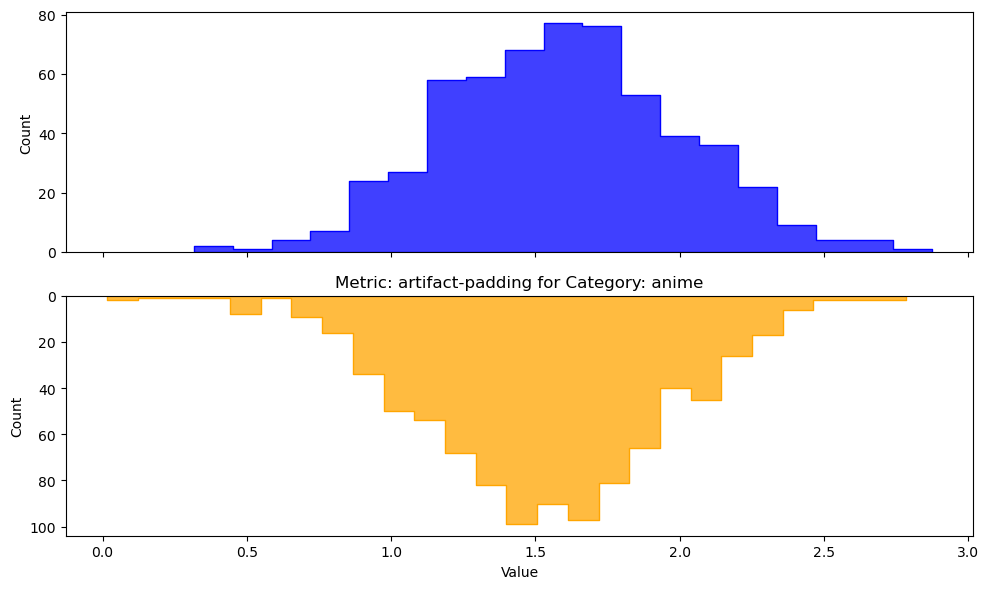

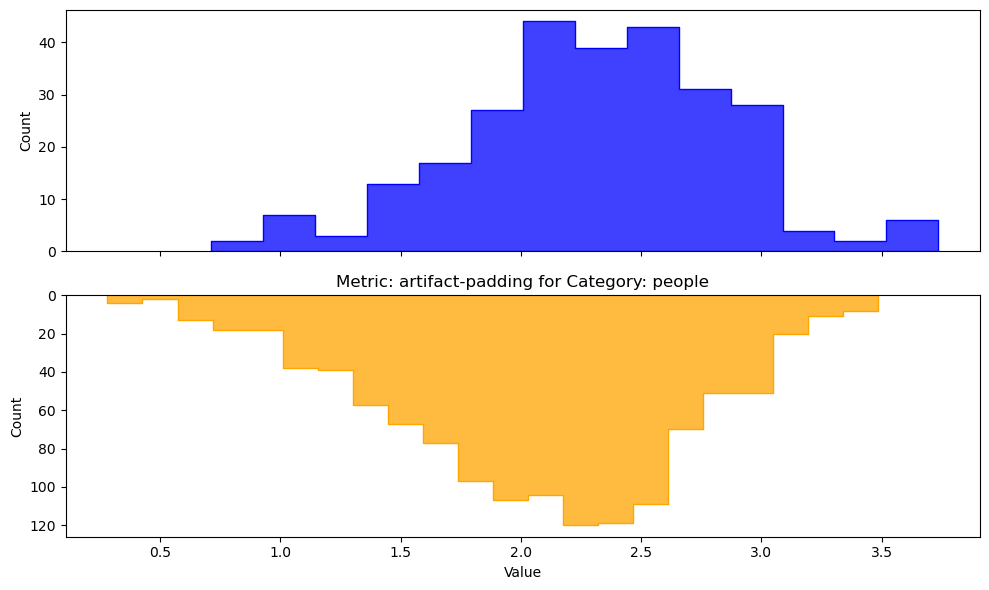

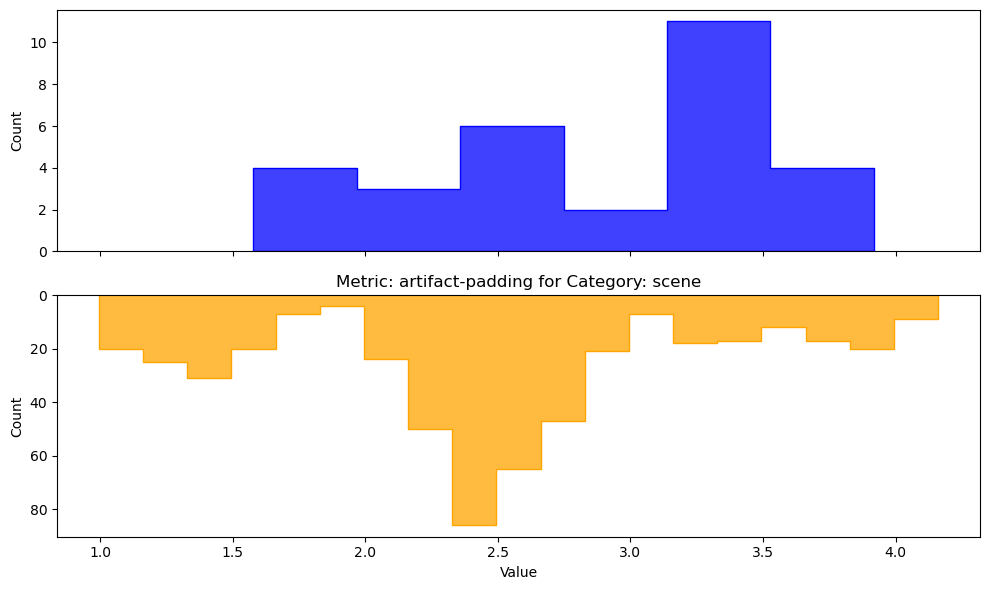

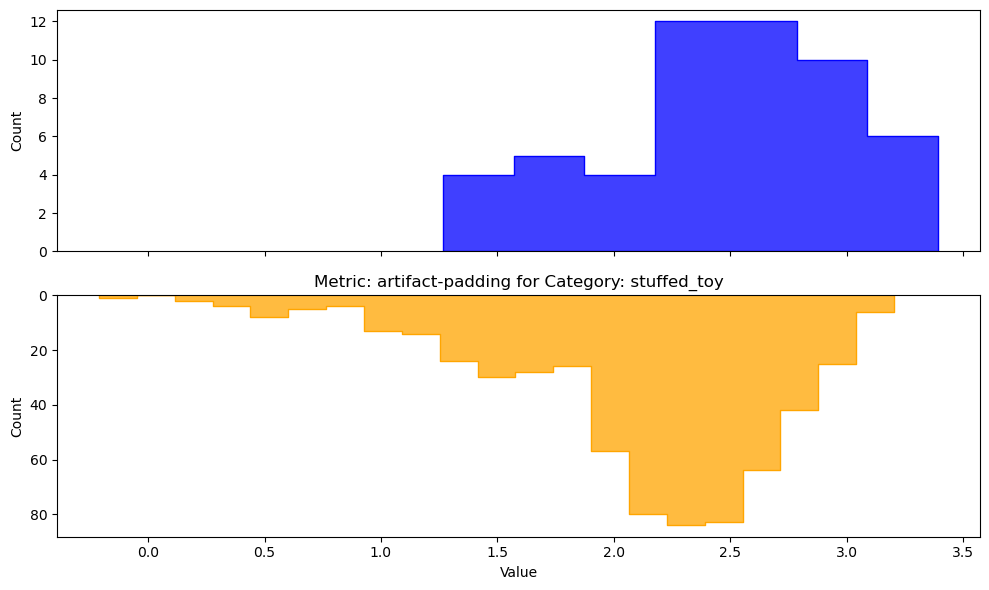

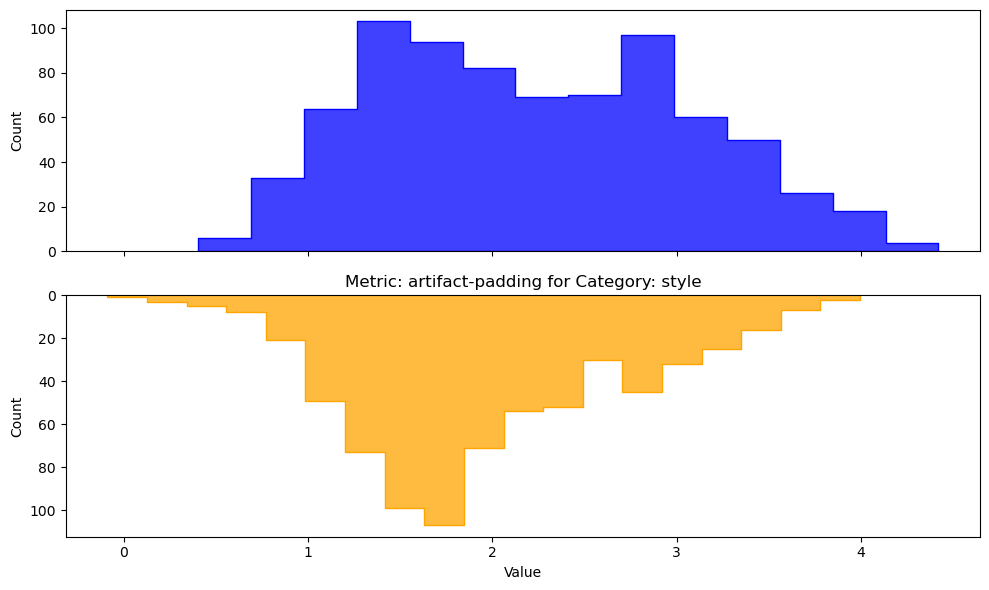

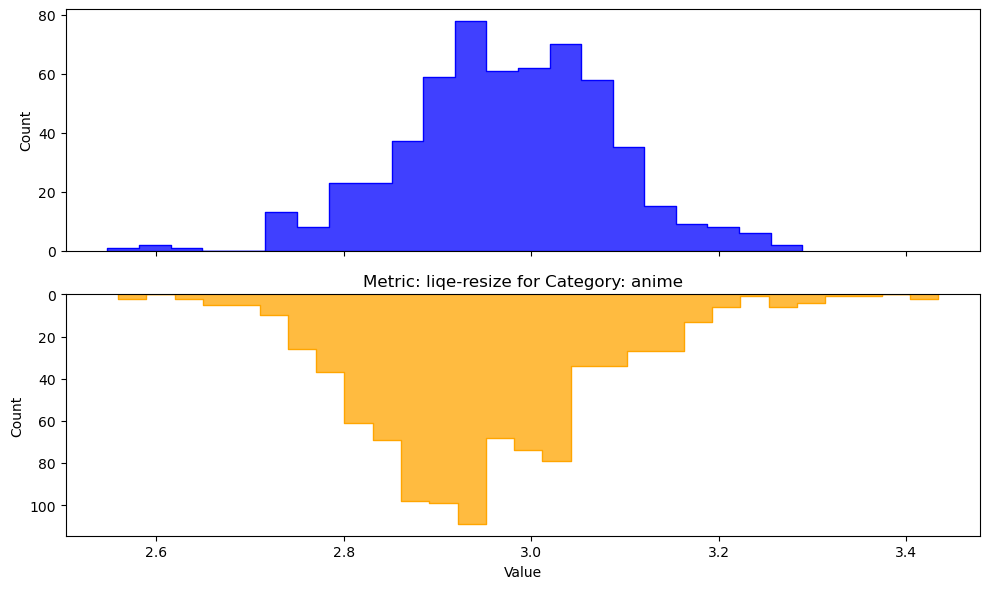

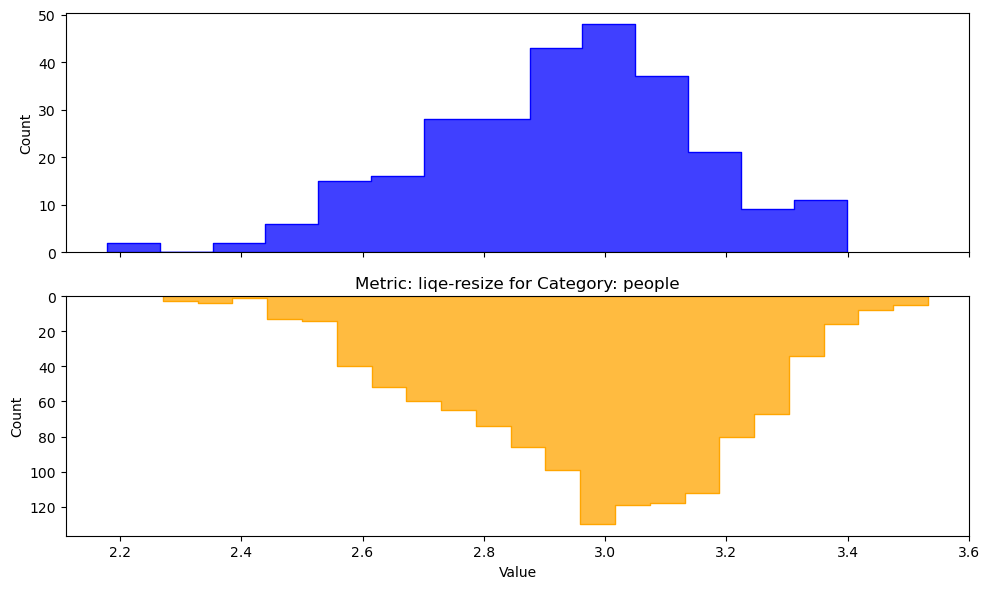

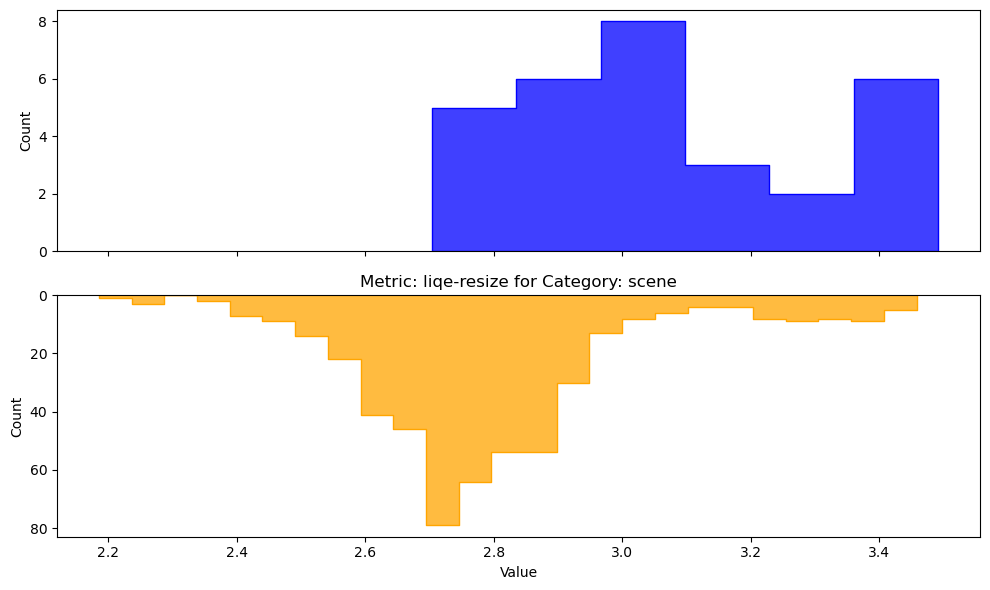

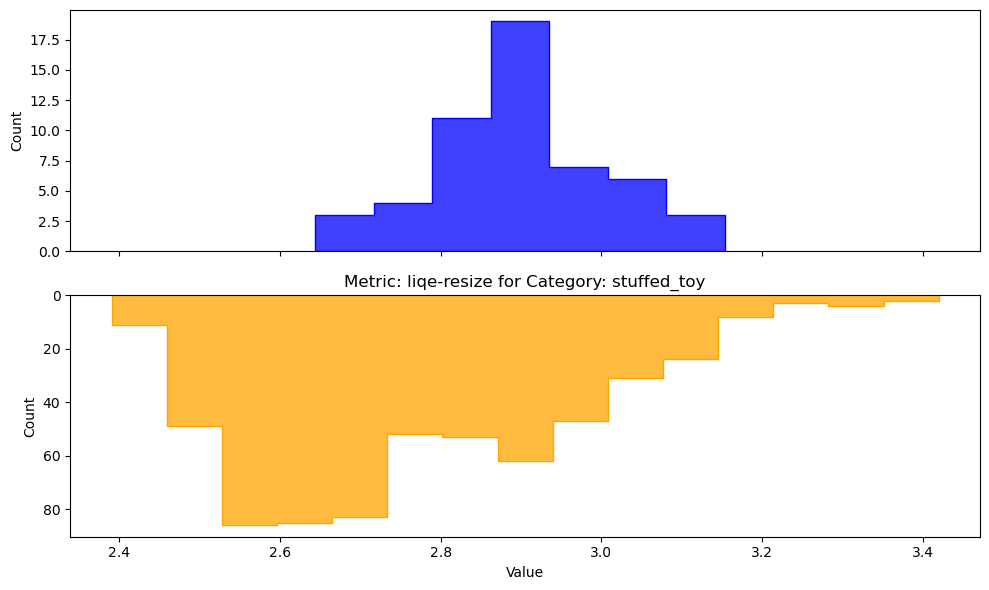

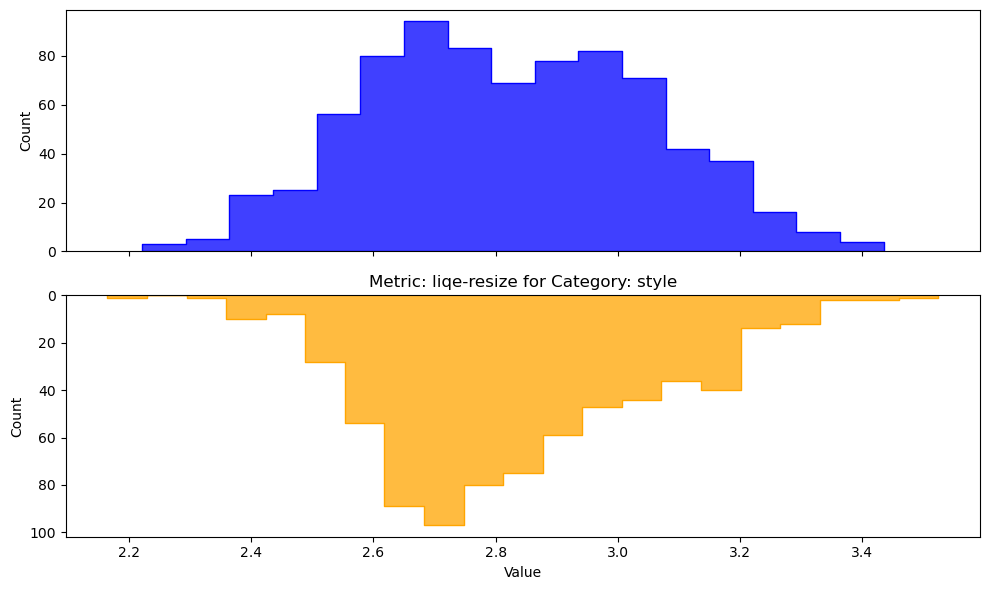

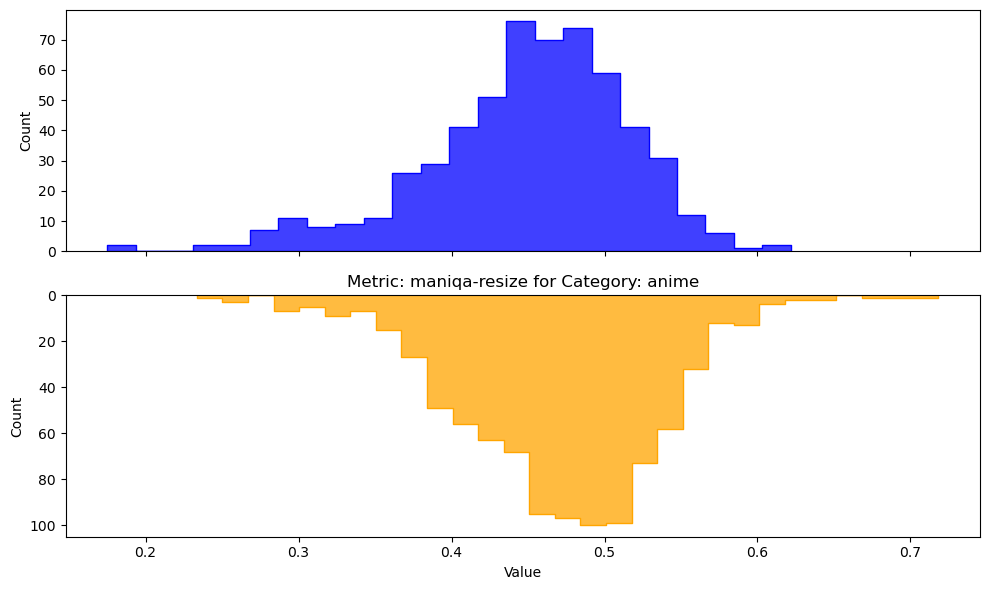

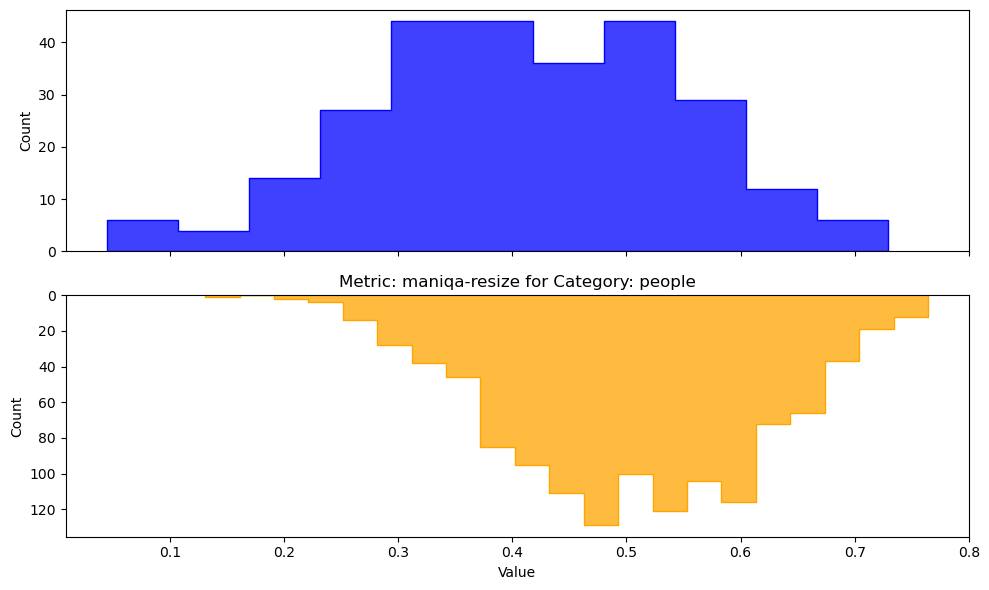

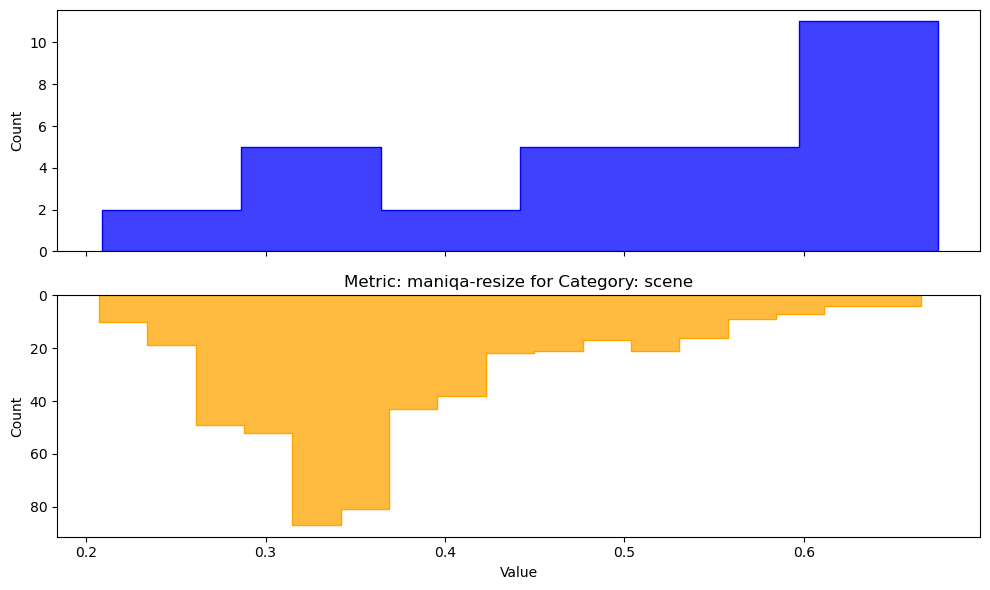

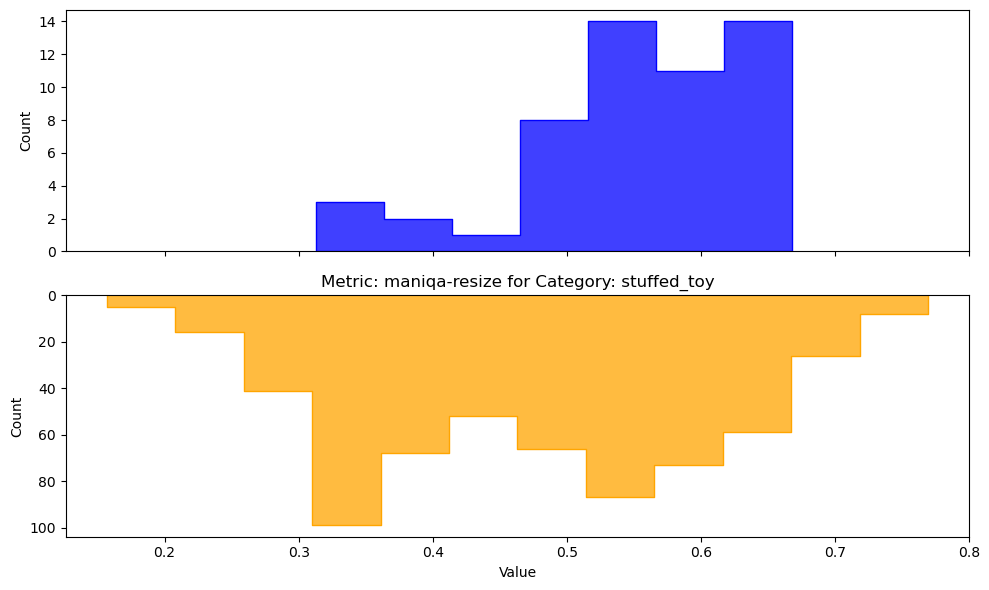

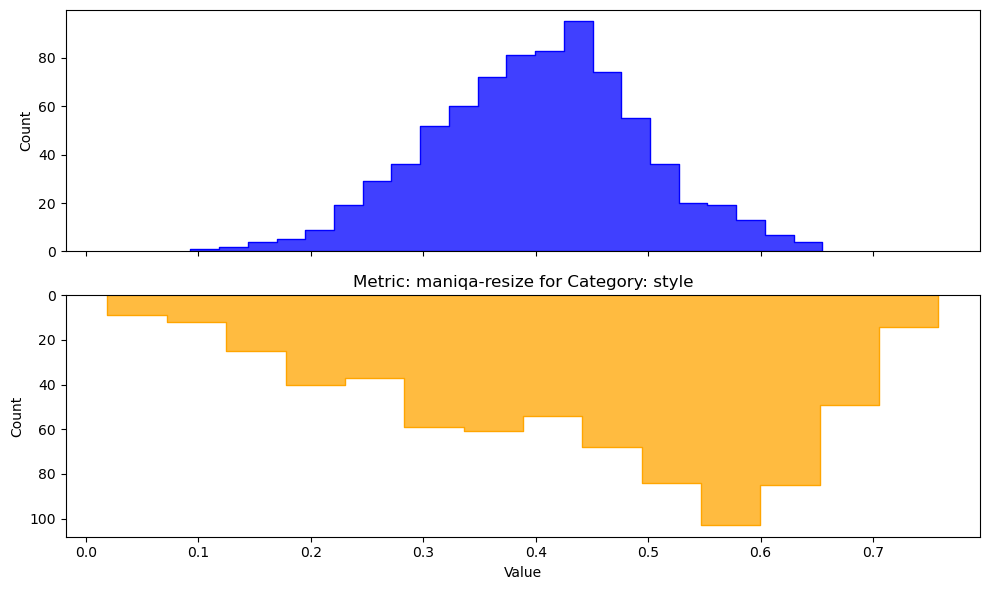

In [50]:
metrics = df_gen.columns[1:4]
categories = df_gen['category'].unique()

for metric in metrics:
    for category in categories:
        plot_mirrored_histogram_category(df, df_gen_lokr, metric, category)
        plt.savefig(f'{save_dir}/{config_name}-{metric}-{category}.png')

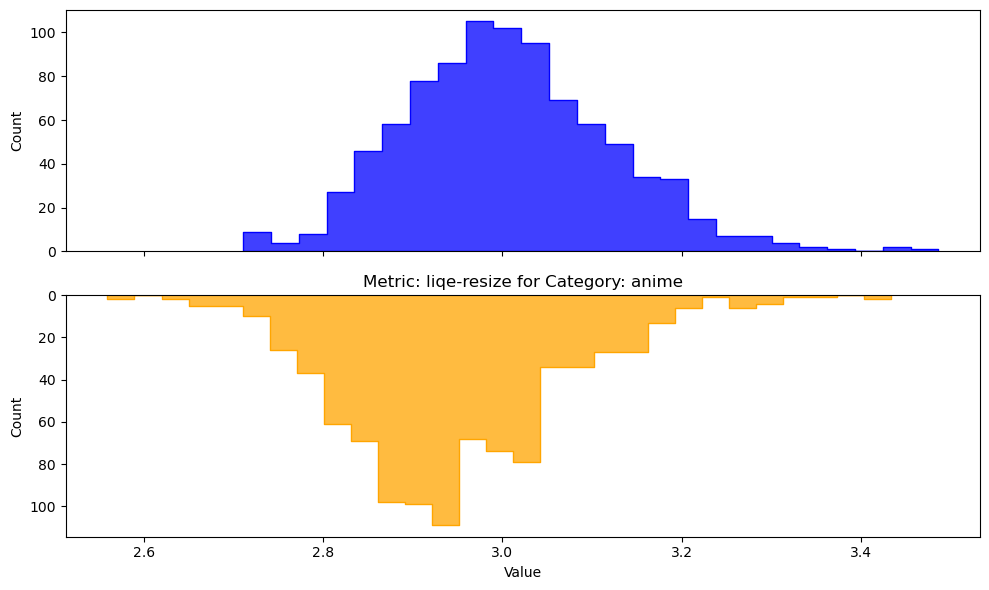

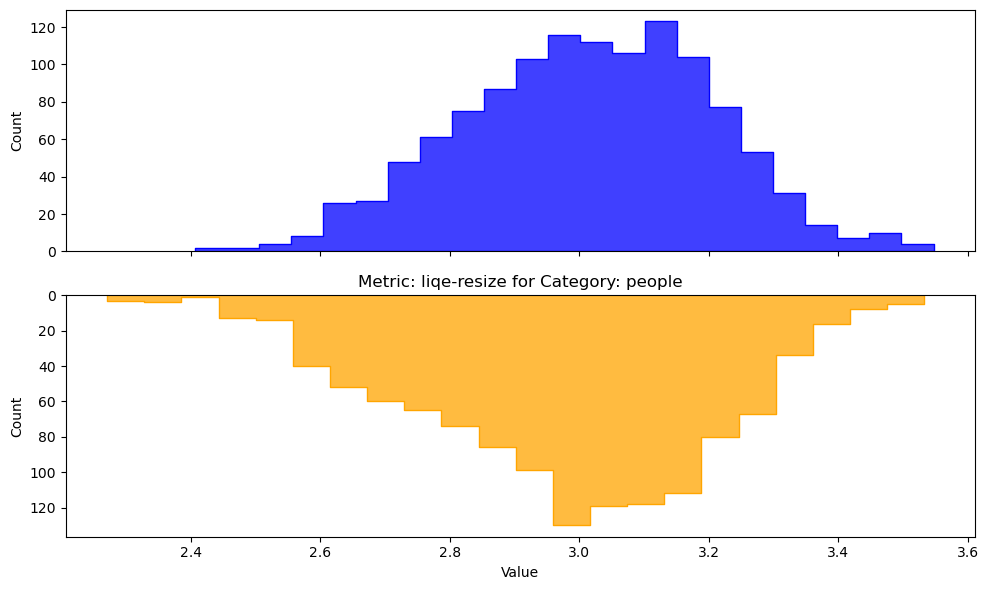

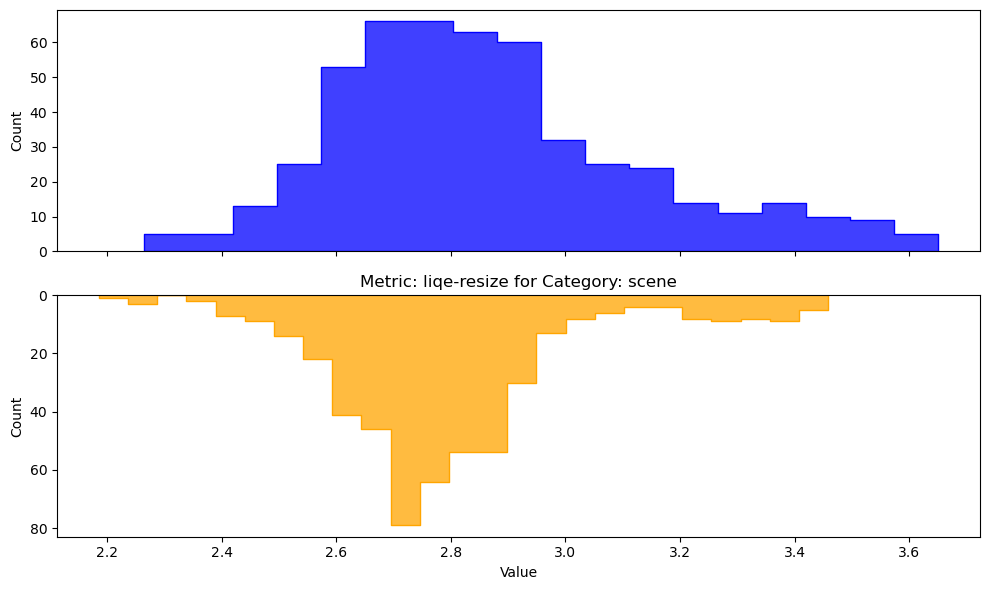

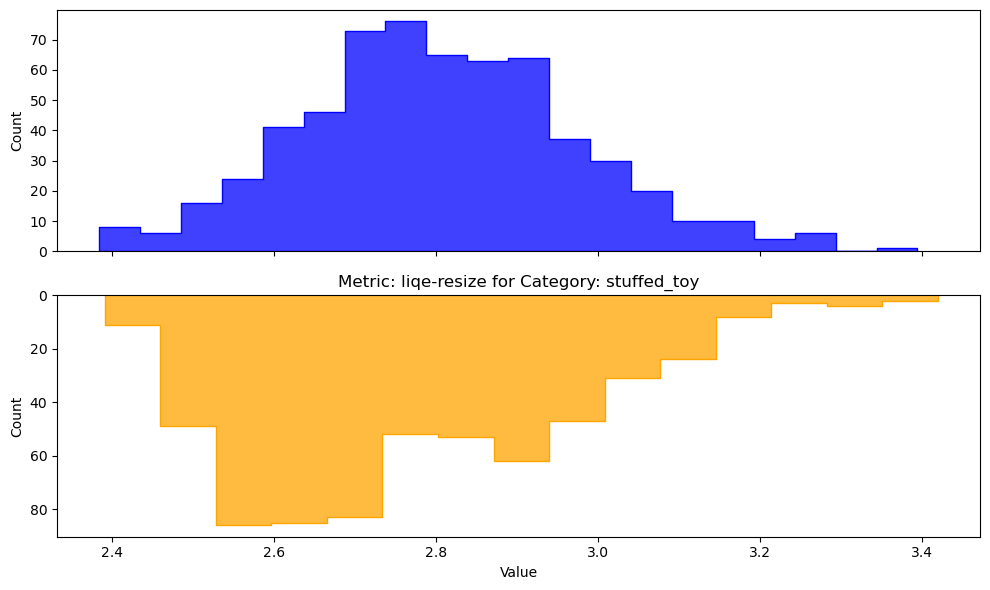

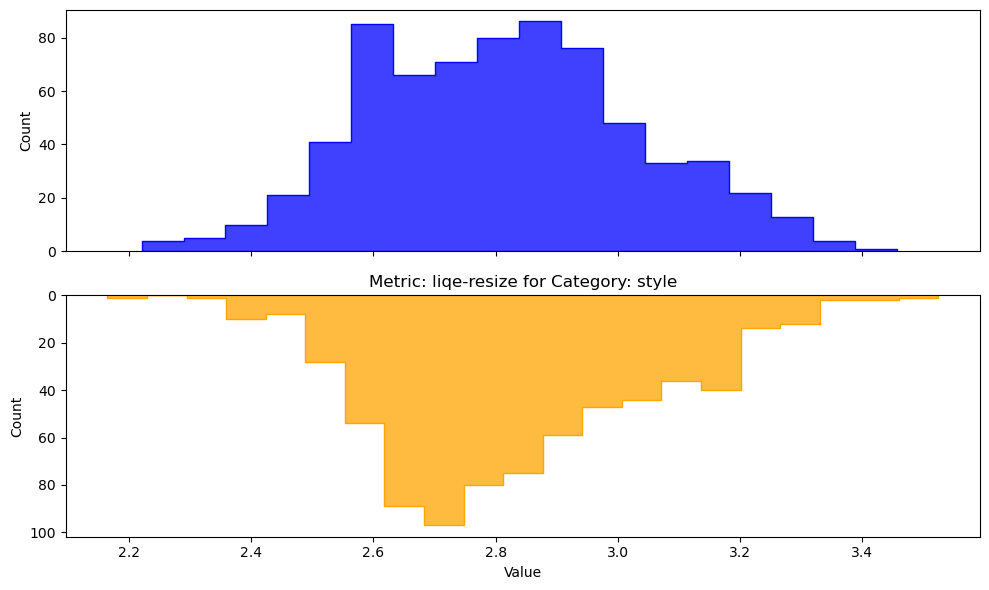

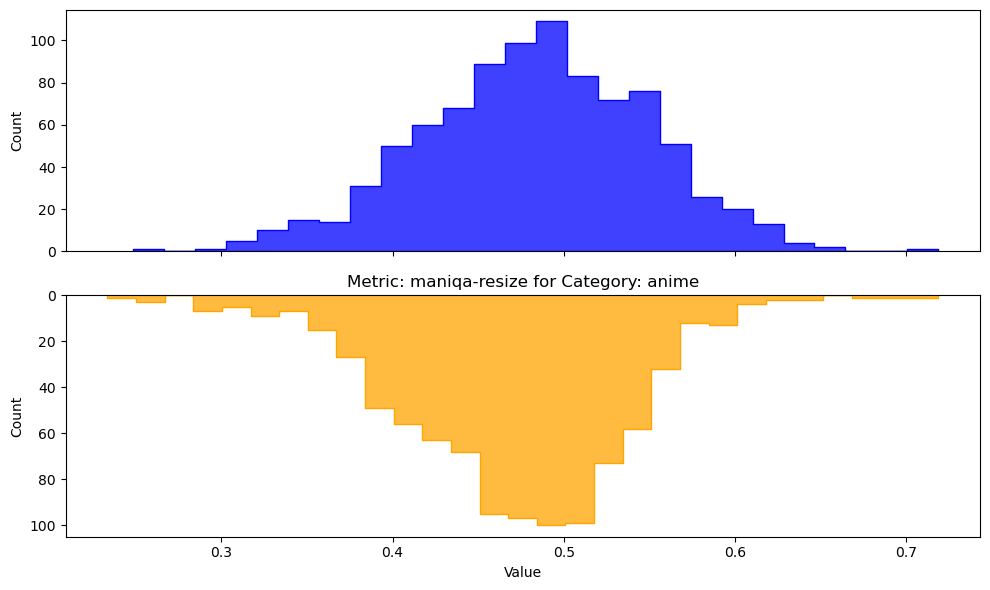

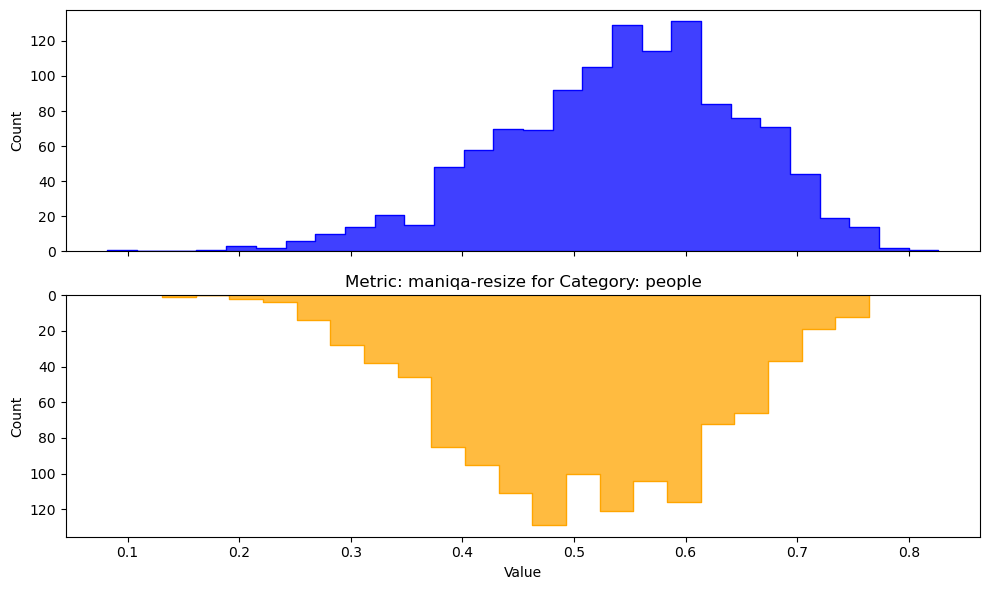

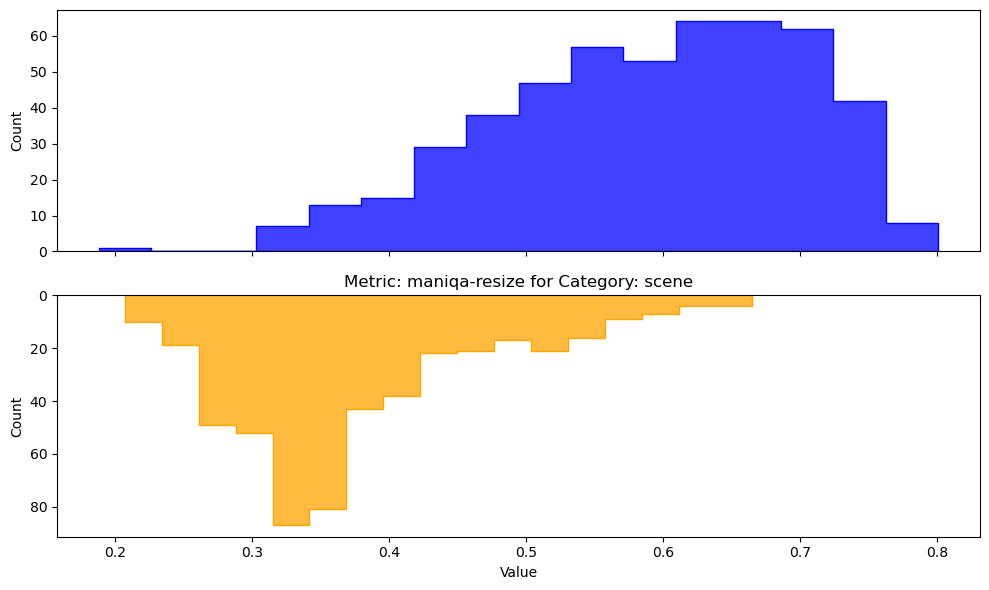

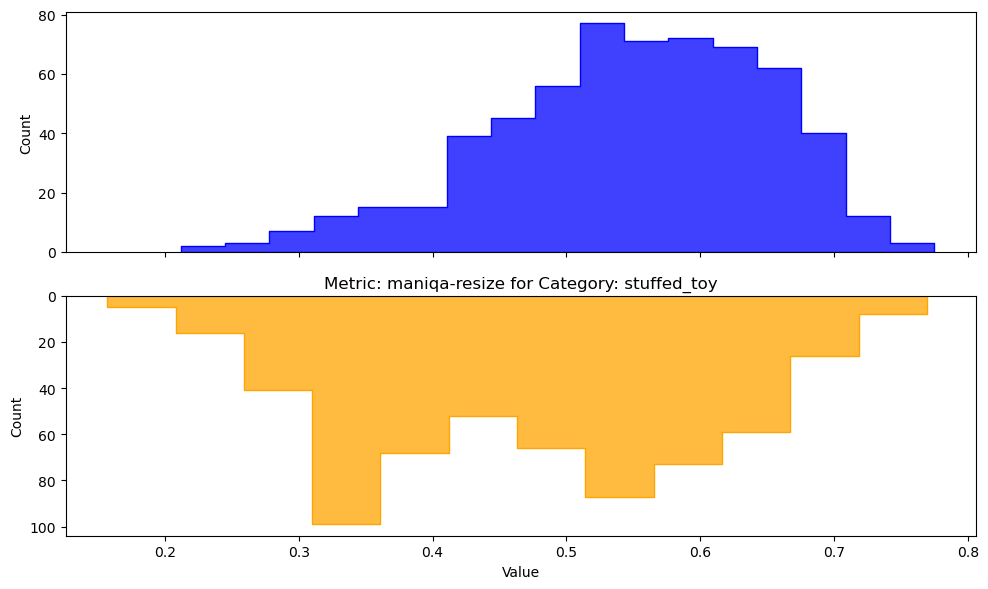

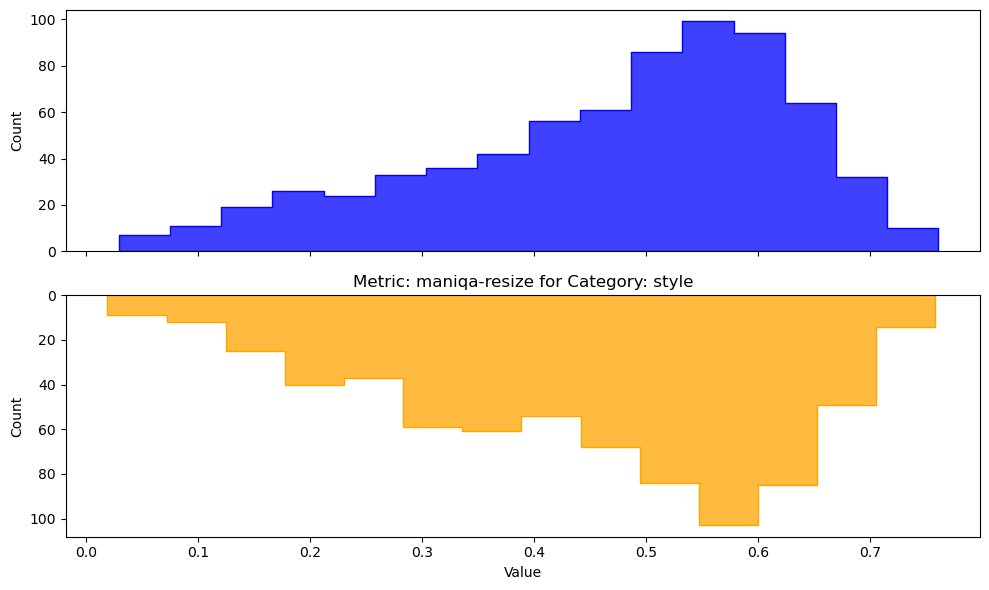

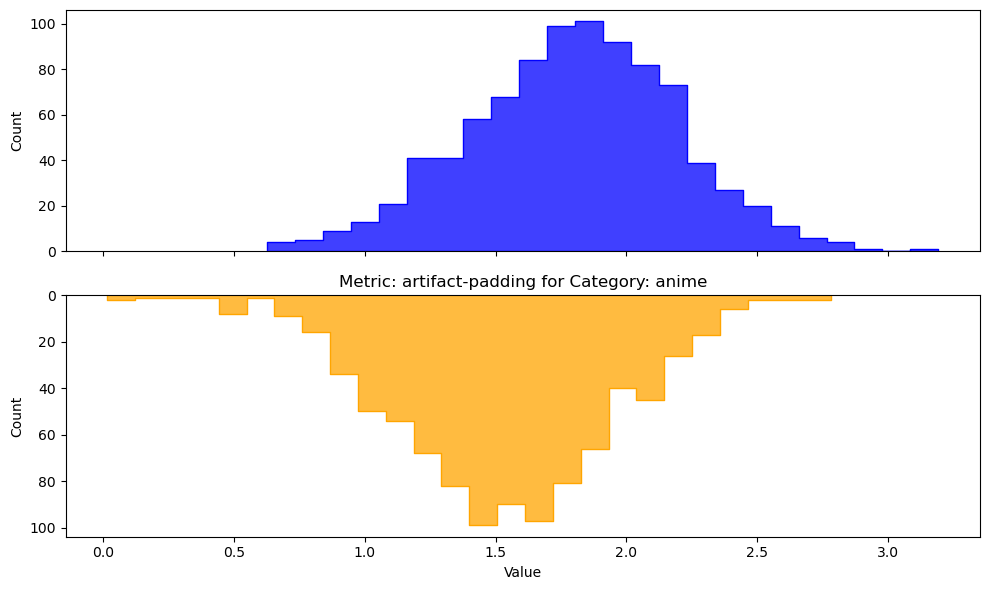

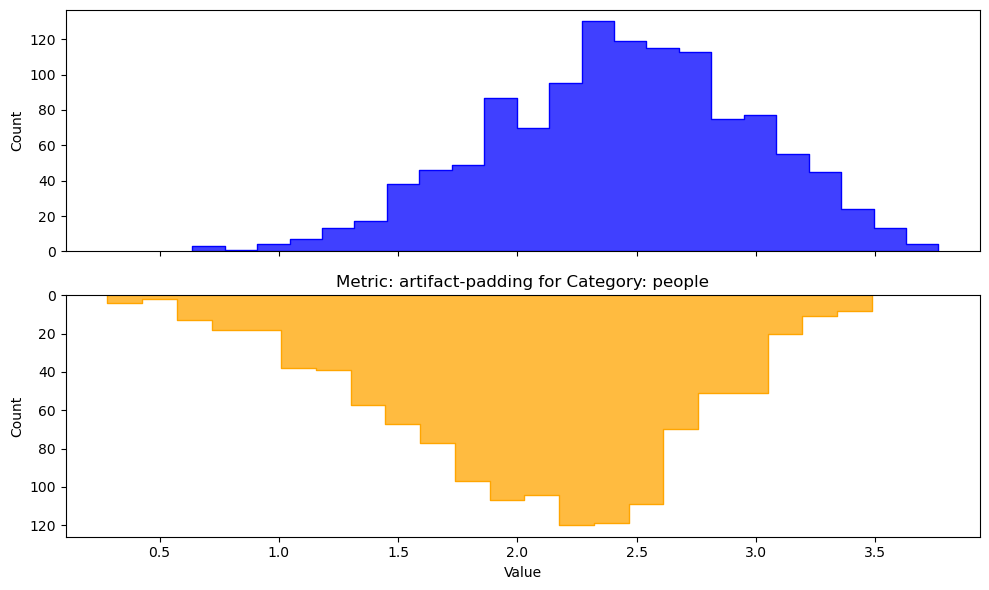

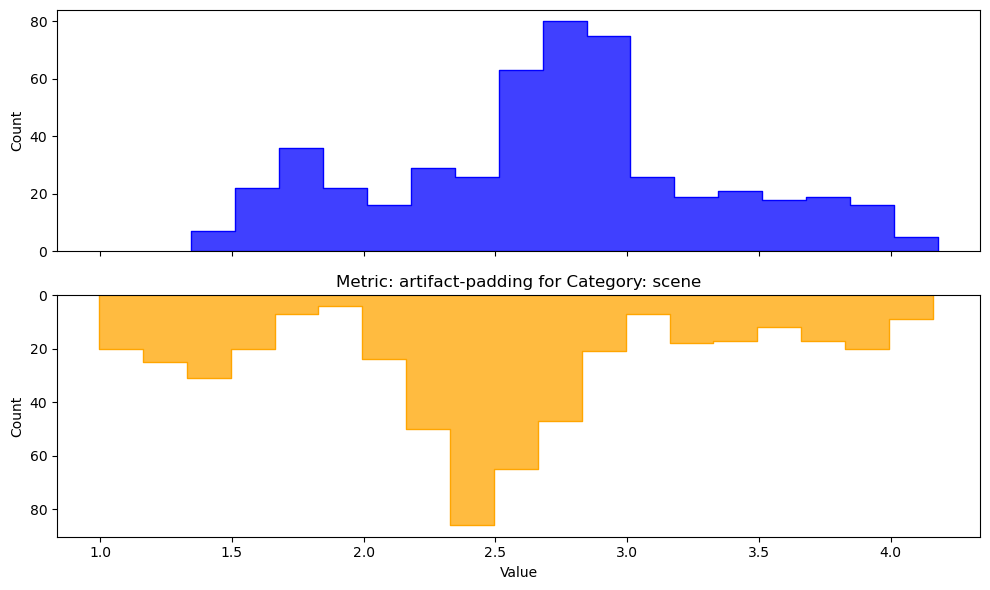

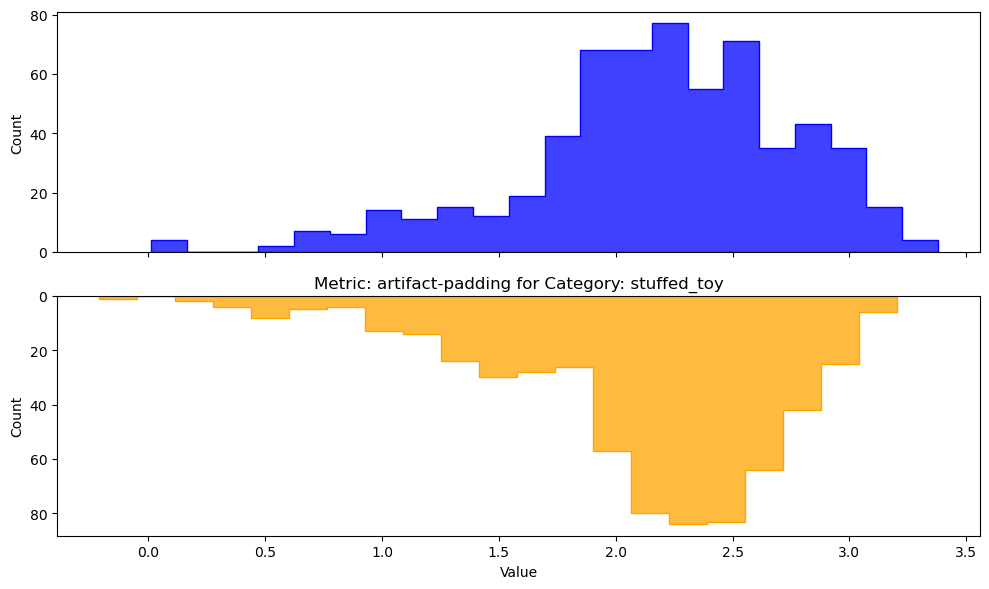

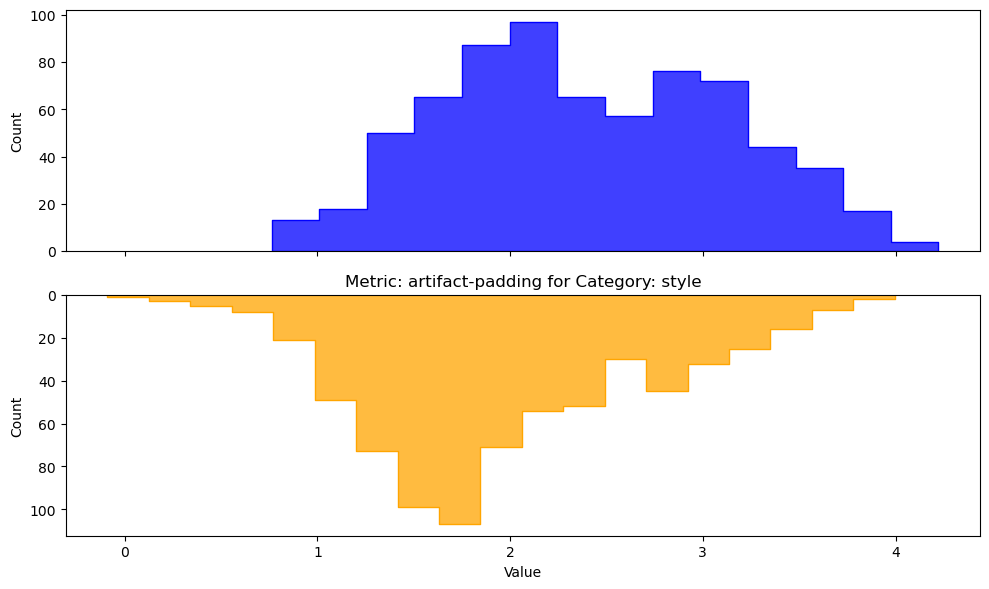

In [57]:
metrics = df_gen.columns[1:4]
categories = df_gen['category'].unique()

for metric in metrics:
    for category in categories:
        plot_mirrored_histogram_category(df_gen, df_gen_lokr, metric, category)
        plt.savefig(f'figures/lora-lokrf4-10/{config_name}-{metric}-{category}.png')

In [51]:
metrics = df_gen.columns[1:4]
categories = df_gen['class'].unique()
os.makedirs(os.path.join(save_dir, 'classes'), exist_ok=True)

for metric in metrics:
    for cls in categories:
        plot_mirrored_histogram_category(df, df_gen, metric, cls, cat='class')
        plt.savefig(f'{save_dir}/classes/{config_name}-{metric}-{cls}.png')
        plt.close()

### Generated images lokr

In [218]:
df_gen_lokr = npz_to_dataframe(
    '/media/sashi/DATA1/datasets_downloaded/lycoris_exp_paper/generated_scores/v15-exp-1053-sd15-lokrf8dinf-lr1e-3-a/',
    None
)

df_gen_lokr['class'] = df_gen_lokr['folder_path'].apply(lambda x: '-'.join(x.split(os.path.sep)[:-1]))

In [219]:
df_gen_lokr

,folder_path,liqe-resize,maniqa-resize,artifact-padding,category,class
0,anime/abukuma/none/in_dist_prompts-image-score...,2.808837,0.469685,1.791016,anime,anime-abukuma-none
1,anime/abukuma/none/in_dist_prompts-image-score...,2.921020,0.604197,1.708984,anime,anime-abukuma-none
2,anime/abukuma/none/in_dist_prompts-image-score...,3.126271,0.527321,1.582031,anime,anime-abukuma-none
3,anime/abukuma/none/in_dist_prompts-image-score...,3.076941,0.461593,1.480469,anime,anime-abukuma-none
4,anime/abukuma/none/in_dist_prompts-image-score...,3.075400,0.534522,1.800781,anime,anime-abukuma-none
...,...,...,...,...,...,...
3895,style/vladimir_borovikovsky/in_dist_prompts-im...,2.756264,0.650183,2.126953,style,style-vladimir_borovikovsky
3896,style/vladimir_borovikovsky/in_dist_prompts-im...,2.553832,0.562430,2.378906,style,style-vladimir_borovikovsky
3897,style/vladimir_borovikovsky/in_dist_prompts-im...,2.868424,0.387125,2.474609,style,style-vladimir_borovikovsky
3898,style/vladimir_borovikovsky/in_dist_prompts-im...,2.918030,0.599651,2.060547,style,style-vladimir_borovikovsky


In [220]:
df_gen_lokr.columns[1:5]

Index(['liqe-resize', 'maniqa-resize', 'artifact-padding', 'category'], dtype='object')

In [221]:
df_gen_lokr

,folder_path,liqe-resize,maniqa-resize,artifact-padding,category,class
0,anime/abukuma/none/in_dist_prompts-image-score...,2.808837,0.469685,1.791016,anime,anime-abukuma-none
1,anime/abukuma/none/in_dist_prompts-image-score...,2.921020,0.604197,1.708984,anime,anime-abukuma-none
2,anime/abukuma/none/in_dist_prompts-image-score...,3.126271,0.527321,1.582031,anime,anime-abukuma-none
3,anime/abukuma/none/in_dist_prompts-image-score...,3.076941,0.461593,1.480469,anime,anime-abukuma-none
4,anime/abukuma/none/in_dist_prompts-image-score...,3.075400,0.534522,1.800781,anime,anime-abukuma-none
...,...,...,...,...,...,...
3895,style/vladimir_borovikovsky/in_dist_prompts-im...,2.756264,0.650183,2.126953,style,style-vladimir_borovikovsky
3896,style/vladimir_borovikovsky/in_dist_prompts-im...,2.553832,0.562430,2.378906,style,style-vladimir_borovikovsky
3897,style/vladimir_borovikovsky/in_dist_prompts-im...,2.868424,0.387125,2.474609,style,style-vladimir_borovikovsky
3898,style/vladimir_borovikovsky/in_dist_prompts-im...,2.918030,0.599651,2.060547,style,style-vladimir_borovikovsky


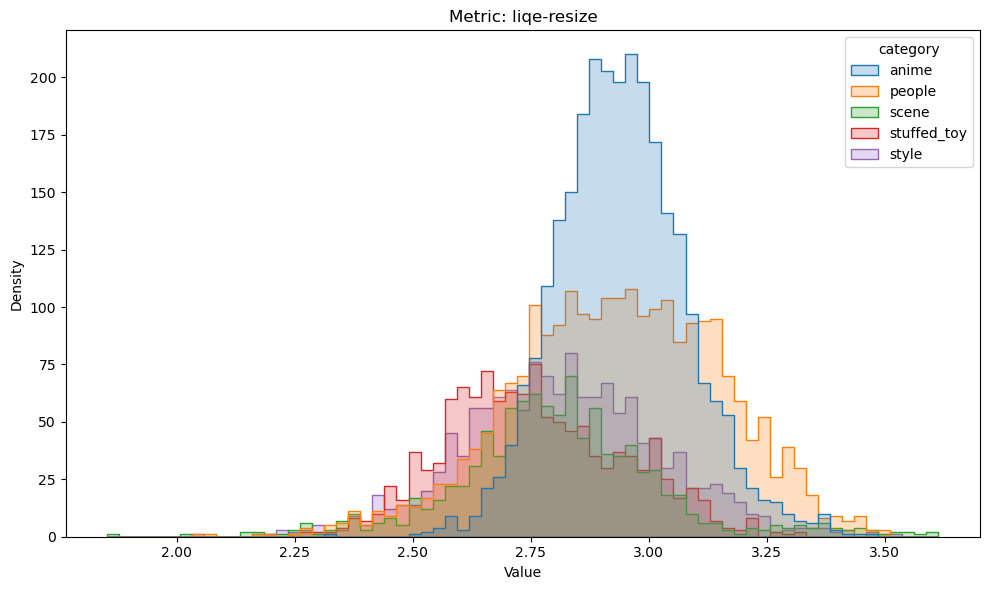

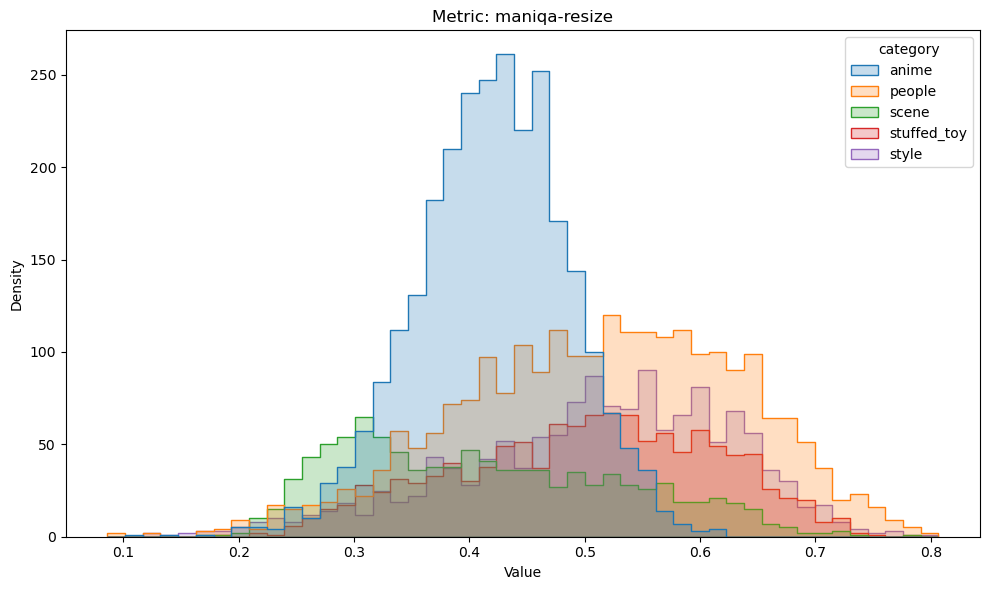

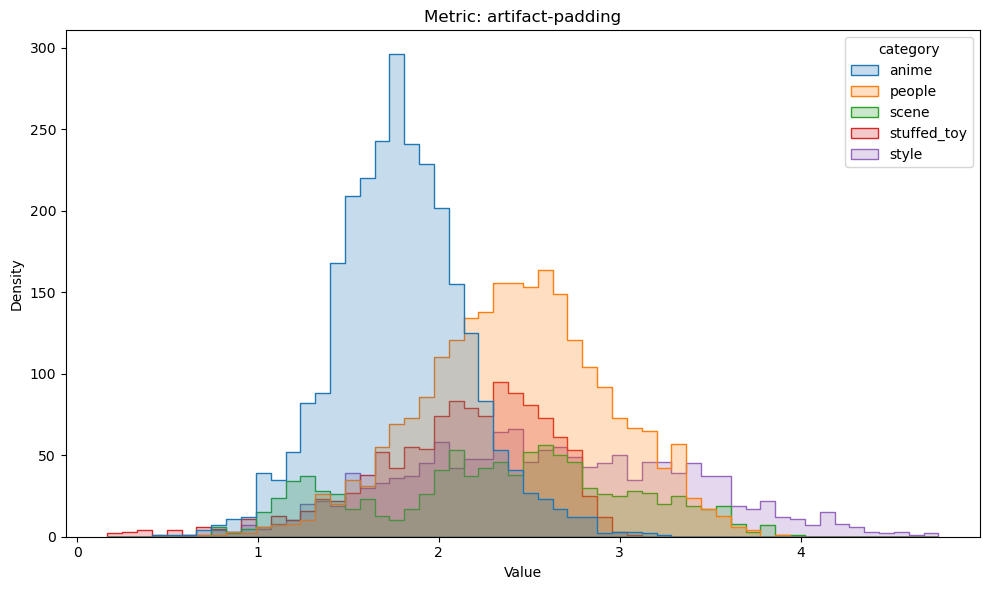

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

df_gen_lokr['dummy_index'] = range(len(df_gen))
metrics = df_gen_lokr.columns[1:4]

for metric in metrics:

    metric_df = df_gen_lokr.pivot(index='dummy_index',
                                  columns='category',
                                  values=metric)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metric_df, element="step", common_norm=False)
    plt.title(f'Metric: {metric}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.savefig(f'figures/generated-{metric}.png')

<AxesSubplot: >

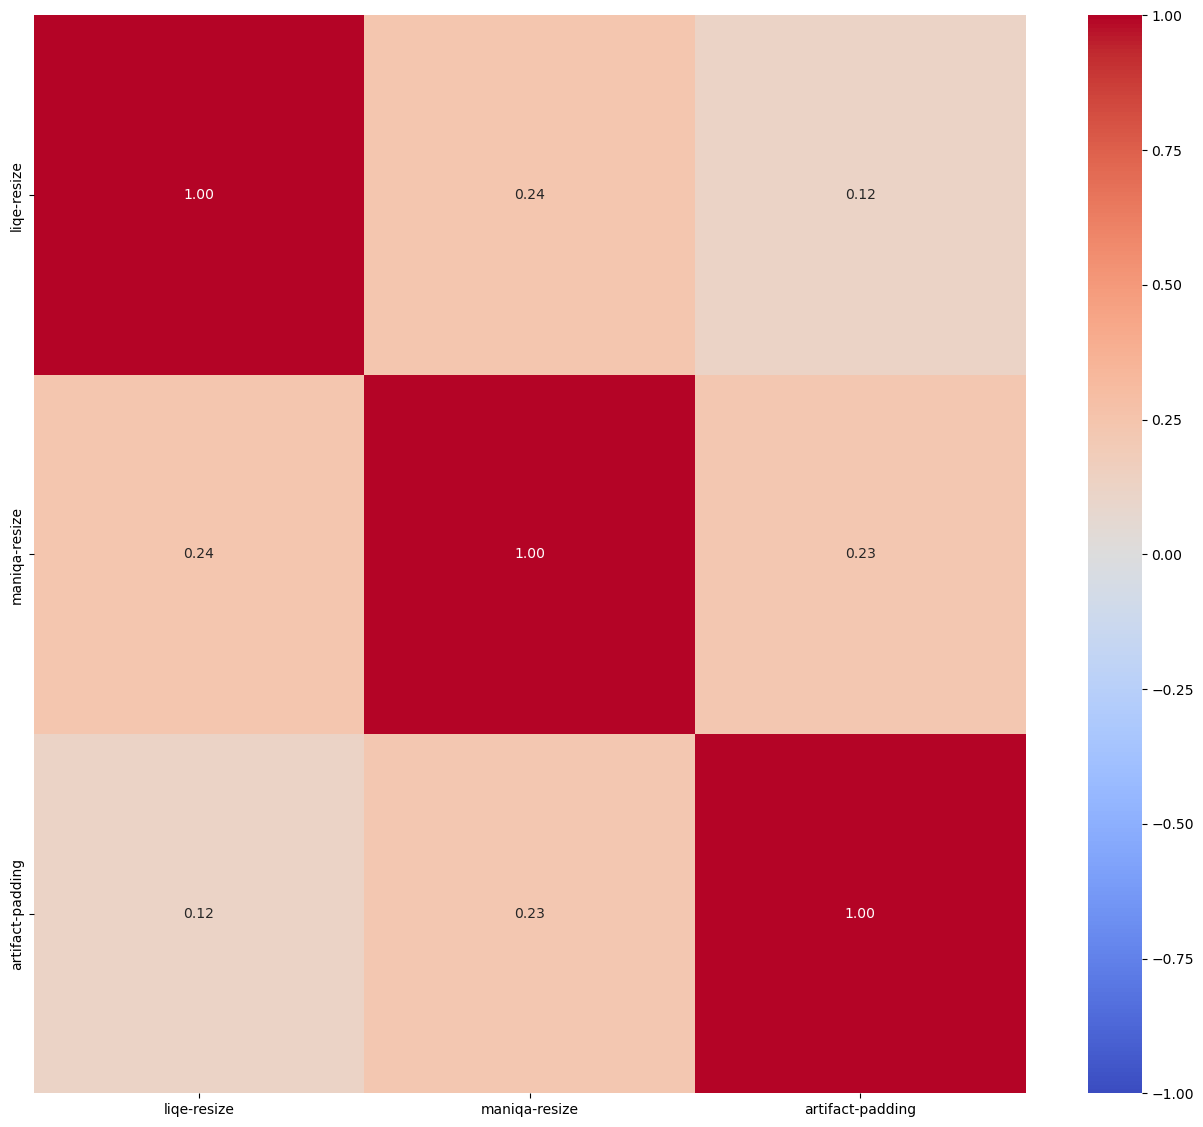

In [222]:
ordered_cols = [
    'liqe-resize',
    'maniqa-resize',
    'artifact-padding'
]
correlation_matrix = df_gen_lokr[ordered_cols].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt=".2f")

In [223]:
df_gen_lokr_sel

,folder_path,liqe-resize,maniqa-resize,artifact-padding,category,source
2700,people/Admiral_Piett/figurine/in_dist_prompts-...,2.908757,0.649110,2.664062,people,df2
2701,people/Admiral_Piett/figurine/in_dist_prompts-...,2.738743,0.558324,2.832031,people,df2
2702,people/Admiral_Piett/figurine/in_dist_prompts-...,2.932643,0.672003,2.902344,people,df2
2703,people/Admiral_Piett/figurine/in_dist_prompts-...,3.252570,0.661600,2.984375,people,df2
2704,people/Admiral_Piett/figurine/in_dist_prompts-...,2.758125,0.704449,2.892578,people,df2
...,...,...,...,...,...,...
7295,stuffed_toy/plushie_tortoise/out_dist_prompts-...,2.714863,0.687705,2.744141,stuffed_toy,df2
7296,stuffed_toy/plushie_tortoise/out_dist_prompts-...,2.852022,0.652066,2.431641,stuffed_toy,df2
7297,stuffed_toy/plushie_tortoise/out_dist_prompts-...,2.717483,0.660290,2.142578,stuffed_toy,df2
7298,stuffed_toy/plushie_tortoise/out_dist_prompts-...,2.698018,0.677429,2.167969,stuffed_toy,df2


<AxesSubplot: >

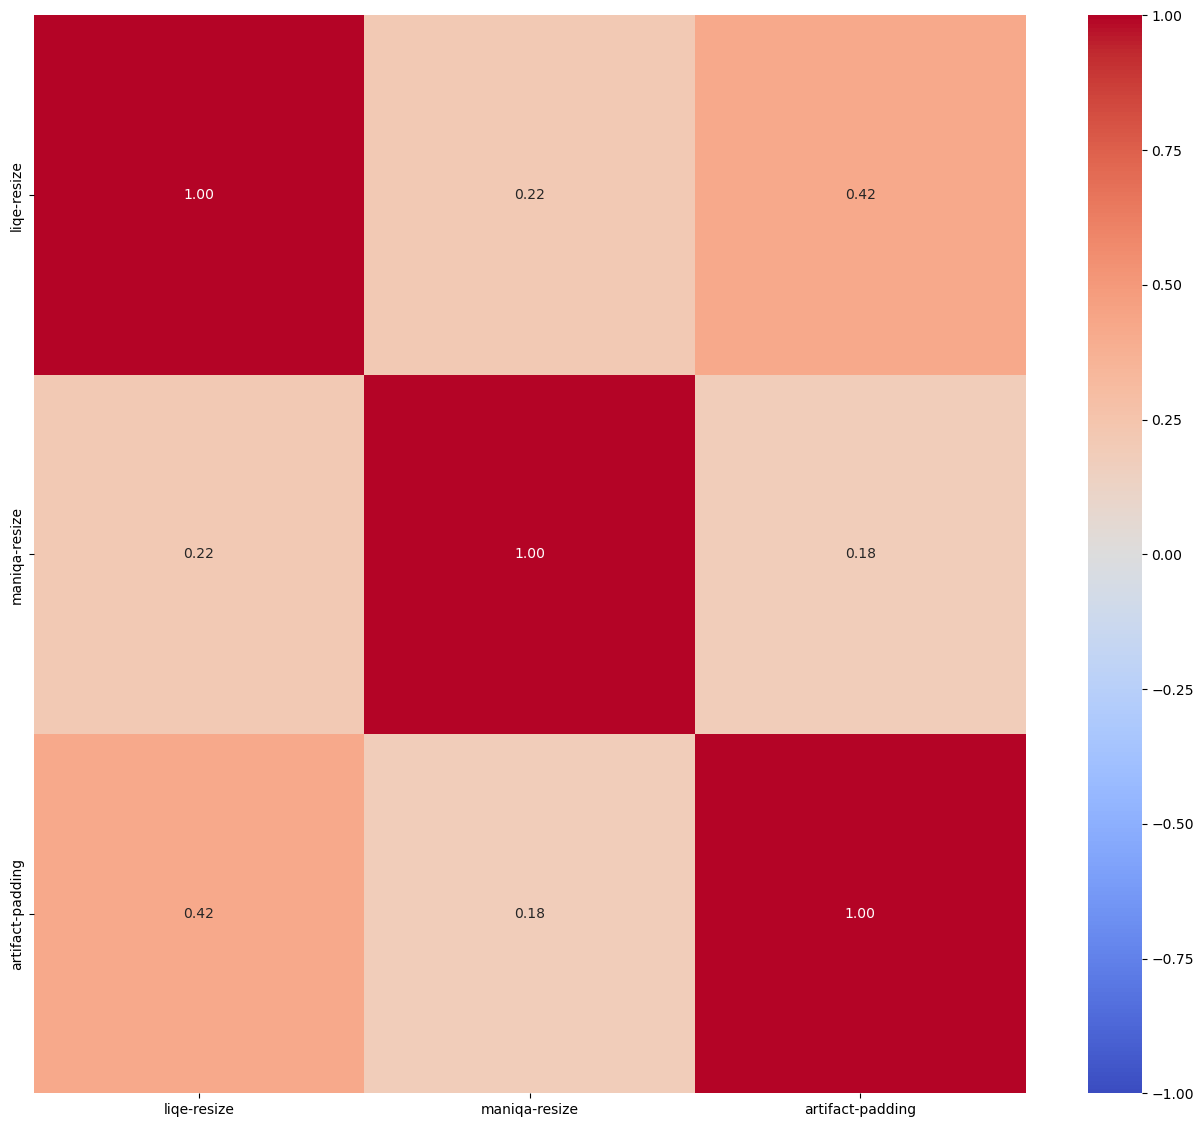

In [224]:
ordered_cols = ['liqe-resize', 'maniqa-resize', 'artifact-padding']
df_gen_lokr_sel = df_gen_lokr[df_gen_lokr['category'].apply(
    lambda x: x not in ['anime', 'style'])]
correlation_matrix = df_gen_lokr_sel[ordered_cols].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            fmt=".2f")

In [147]:
def plot_mirrored_histogram(df1, df2, metric):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 10))

    # Stack the dataframes with an indicator column
    df1['source'] = 'df1'
    df2['source'] = 'df2'
    combined = pd.concat([df1, df2])

    sns.histplot(data=combined[combined['source'] == 'df1'],
                 x=metric,
                 hue='category',
                 element="step",
                 ax=axes[0])
    sns.histplot(data=combined[combined['source'] == 'df2'],
                 x=metric,
                 hue='category',
                 element="step",
                 ax=axes[1])

    axes[1].invert_yaxis()

    plt.subplots_adjust(hspace=0)
    plt.title(f'Metric: {metric}, real on top, fake at bottom')
    plt.xlabel('Value')
    plt.tight_layout()

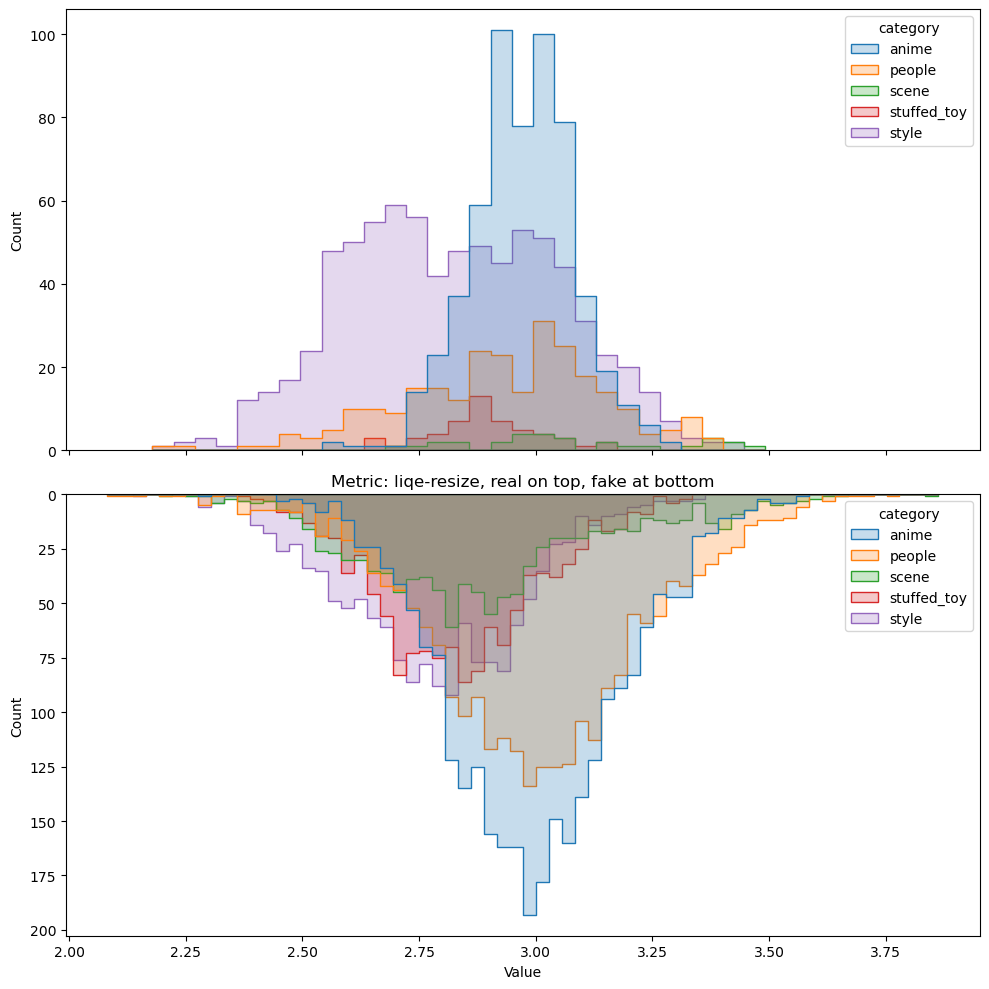

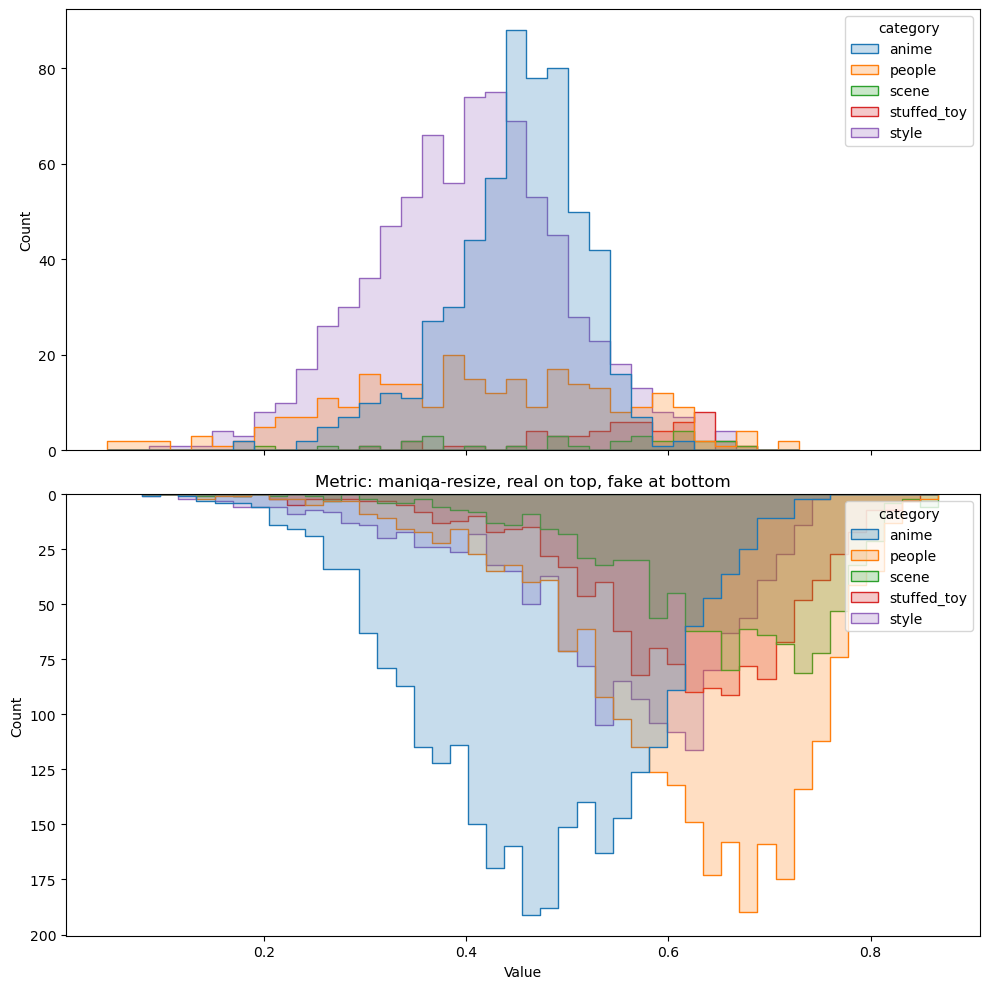

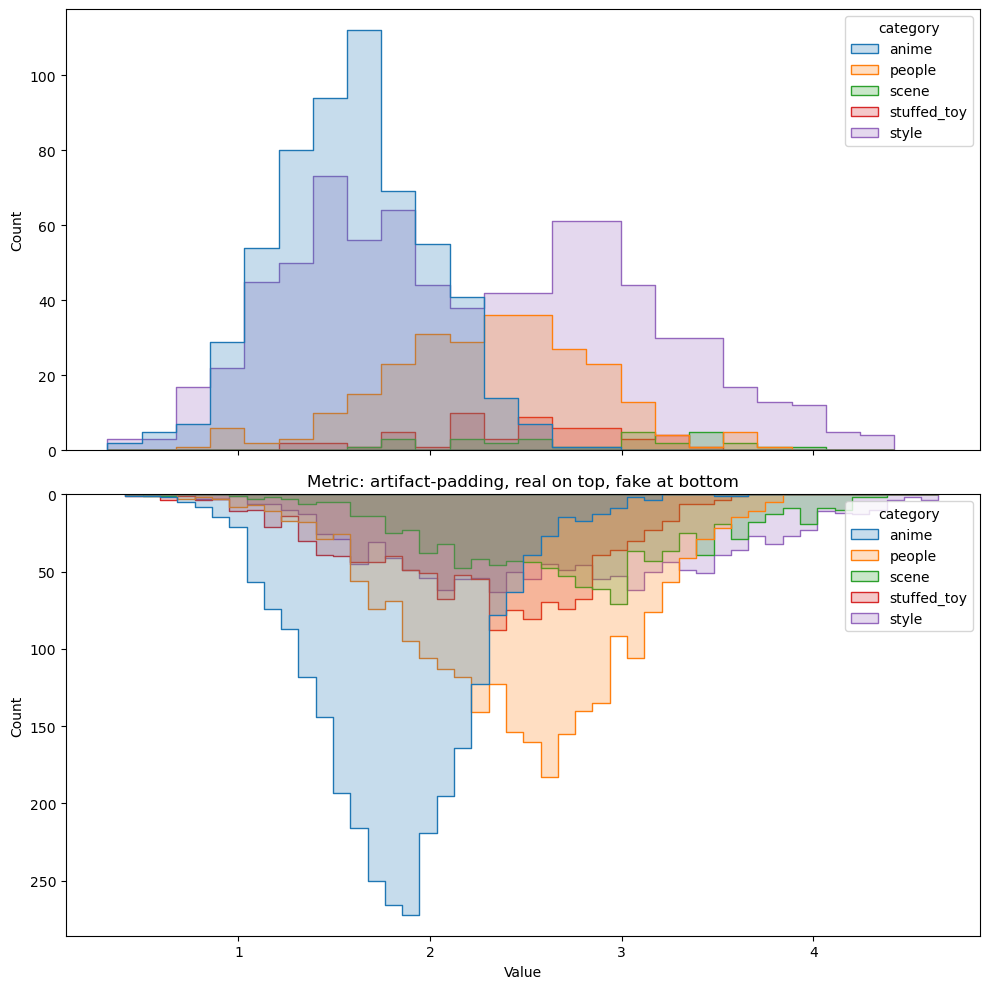

In [156]:
metrics = df_gen_lokr.columns[1:4]

for metric in metrics:
    plot_mirrored_histogram(df, df_gen_lokr, metric)
    plt.savefig(f'figures/lokr/{metric}.png')

In [157]:
df_gen.columns[1:4]

Index(['liqe-resize', 'maniqa-resize', 'artifact-padding'], dtype='object')

In [225]:
def plot_mirrored_histogram_category(df1, df2, metric, cat, cat_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

    sns.histplot(data=df1[df1[cat] == cat_name],
                 x=metric,
                 element="step",
                 ax=axes[0],
                 color='blue',
                 label='df1')
    sns.histplot(data=df2[df2[cat] == cat_name],
                 x=metric,
                 element="step",
                 ax=axes[1],
                 color='orange',
                 label='df2')

    axes[1].invert_yaxis()

    plt.subplots_adjust(hspace=0)
    plt.title(f'Metric: {metric} for Category: {cat_name}')
    plt.xlabel('Value')
    plt.tight_layout()

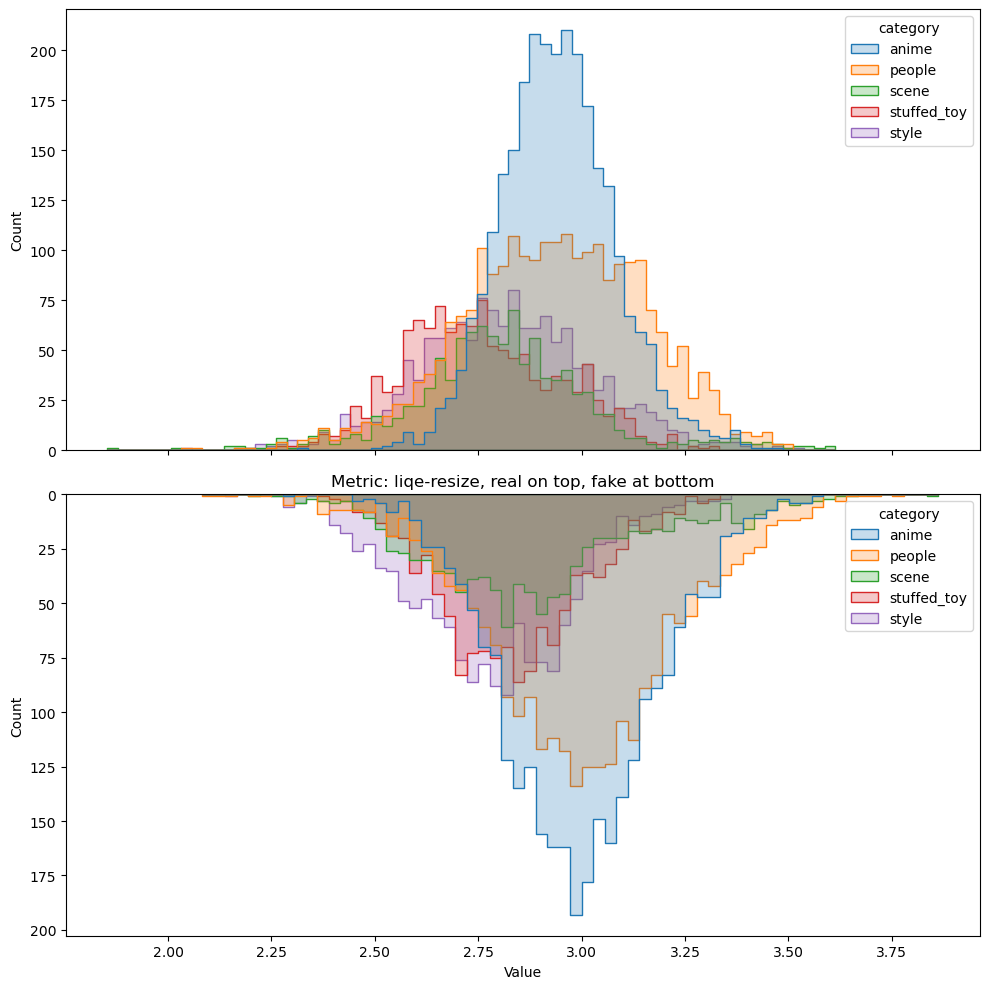

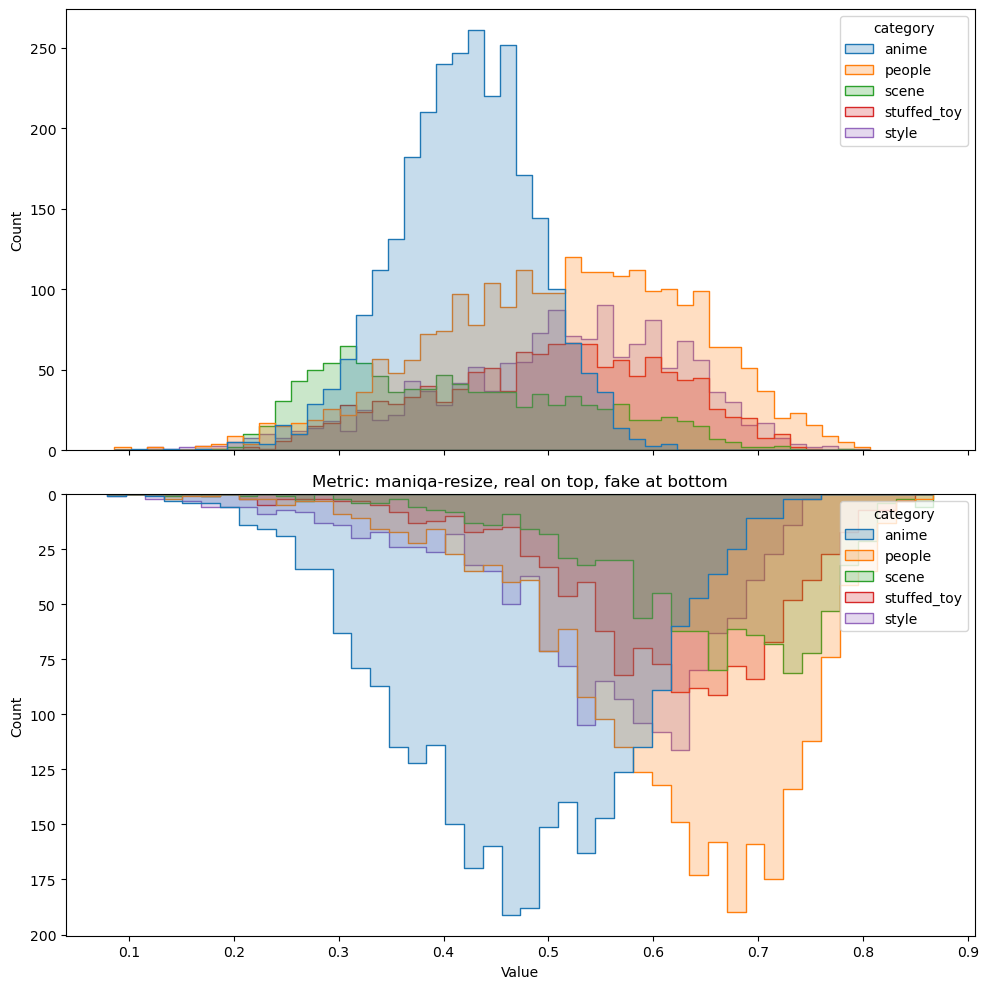

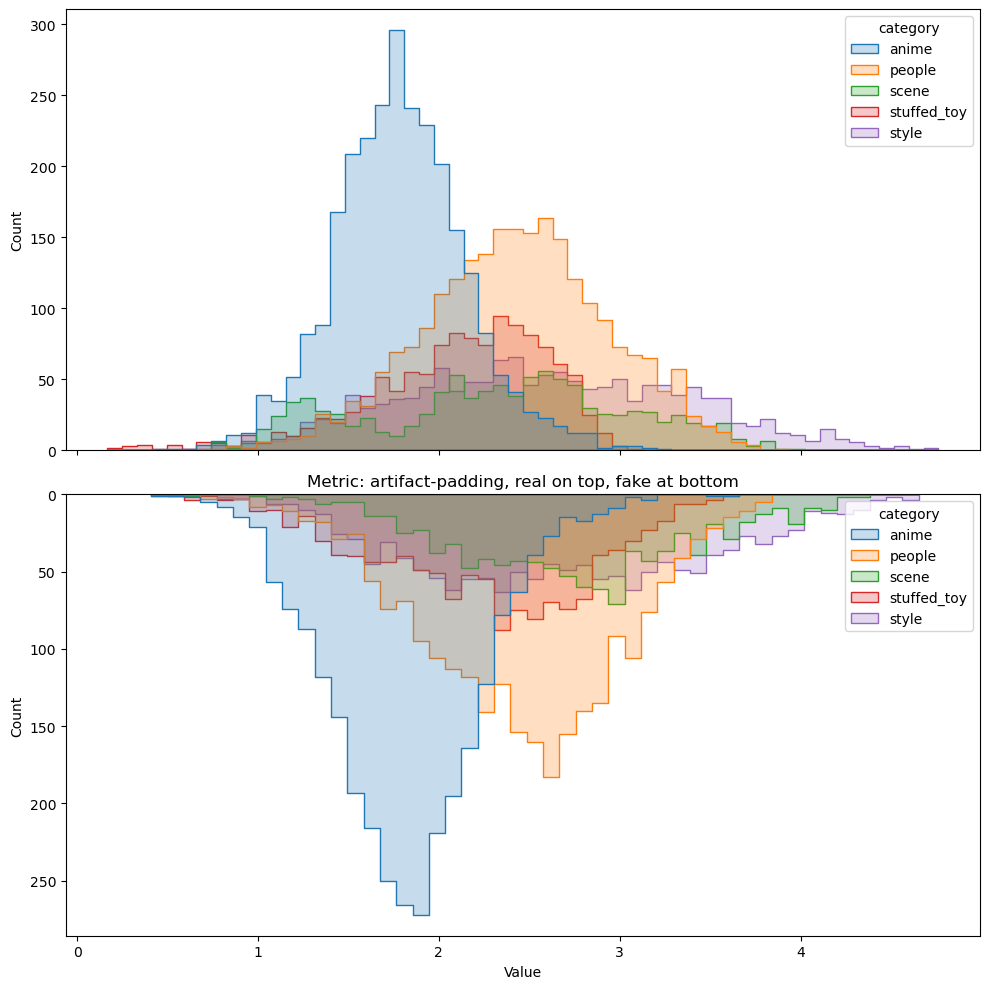

In [169]:
metrics = df_gen_lokr.columns[1:4]

for metric in metrics:
    plot_mirrored_histogram(df_gen, df_gen_lokr, metric)
    plt.savefig(f'figures/db_lokr/{metric}.png')

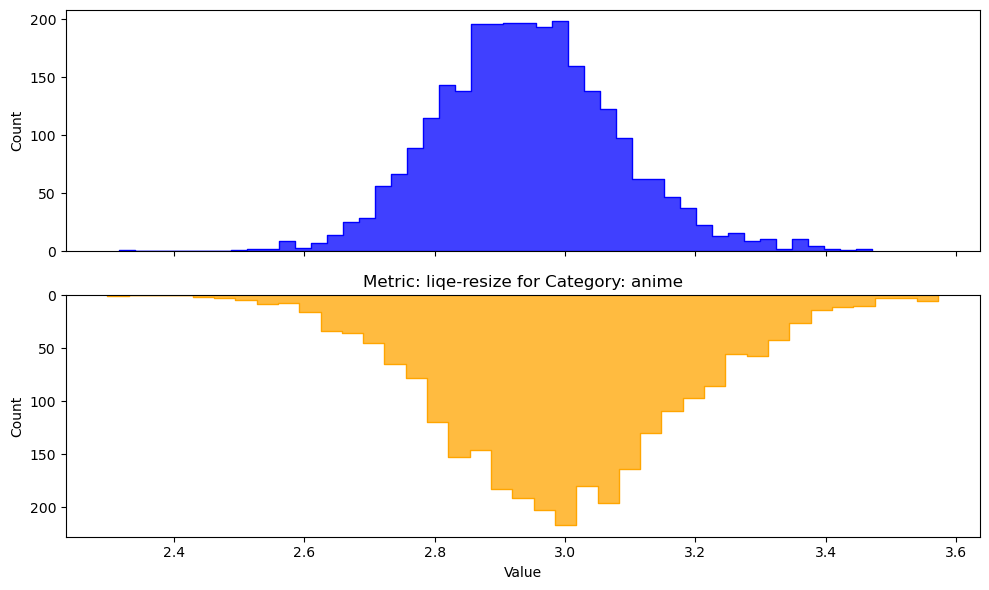

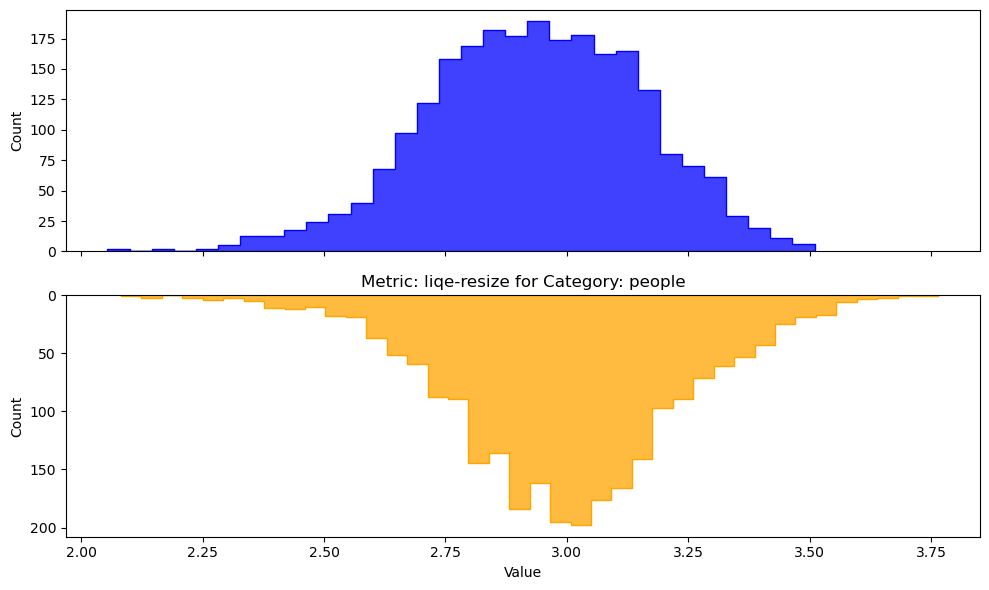

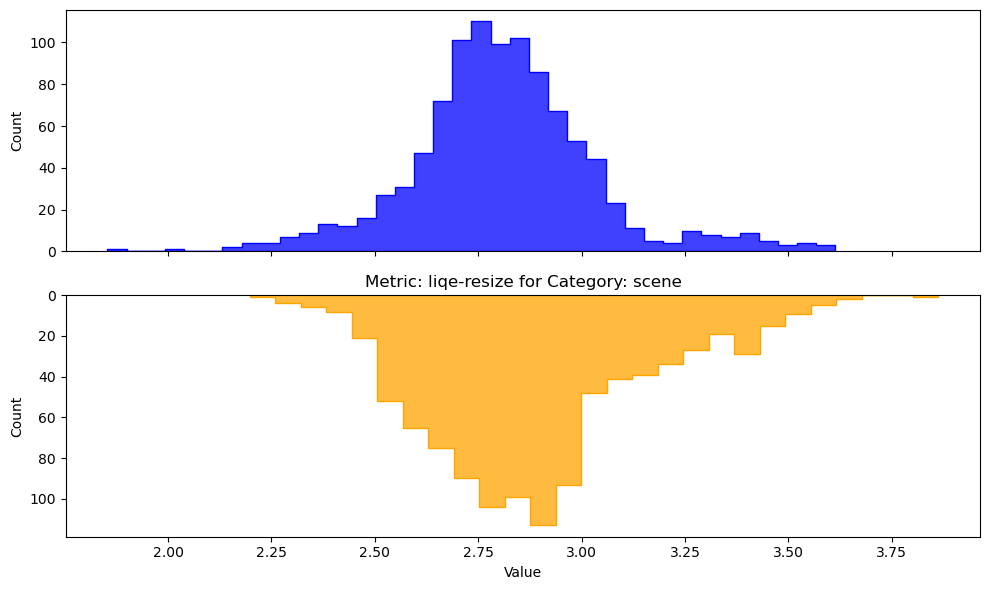

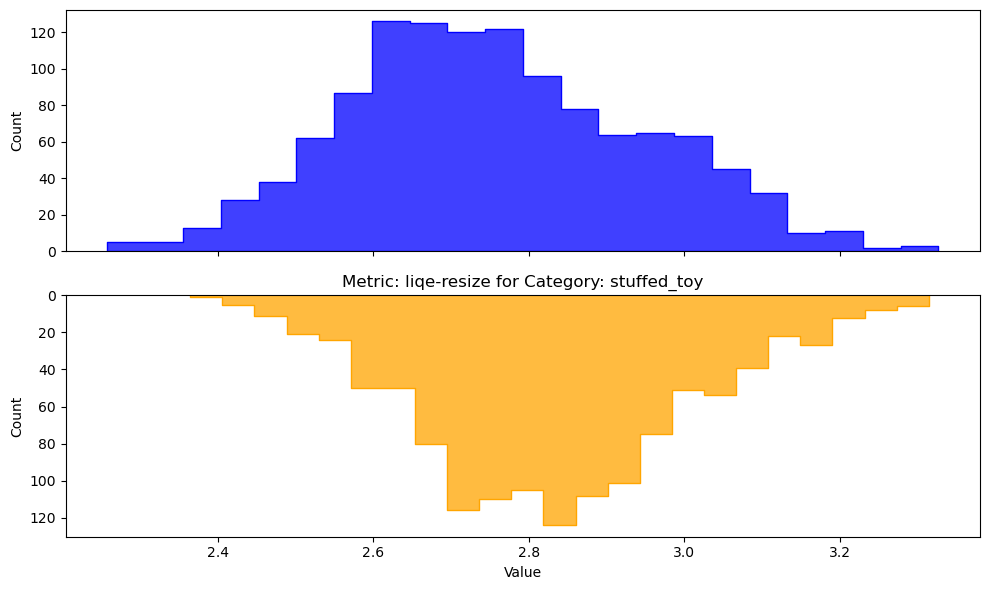

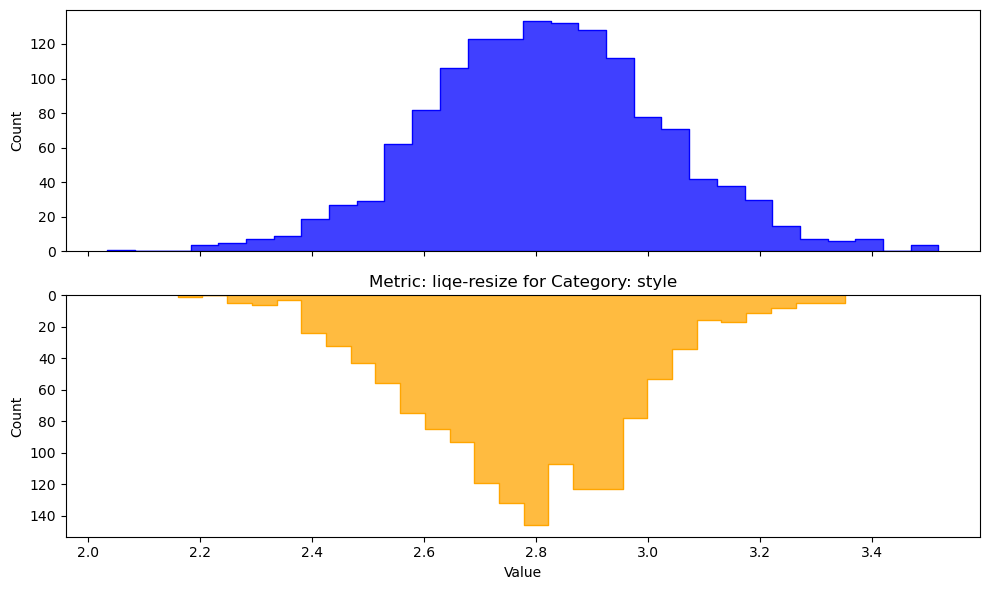

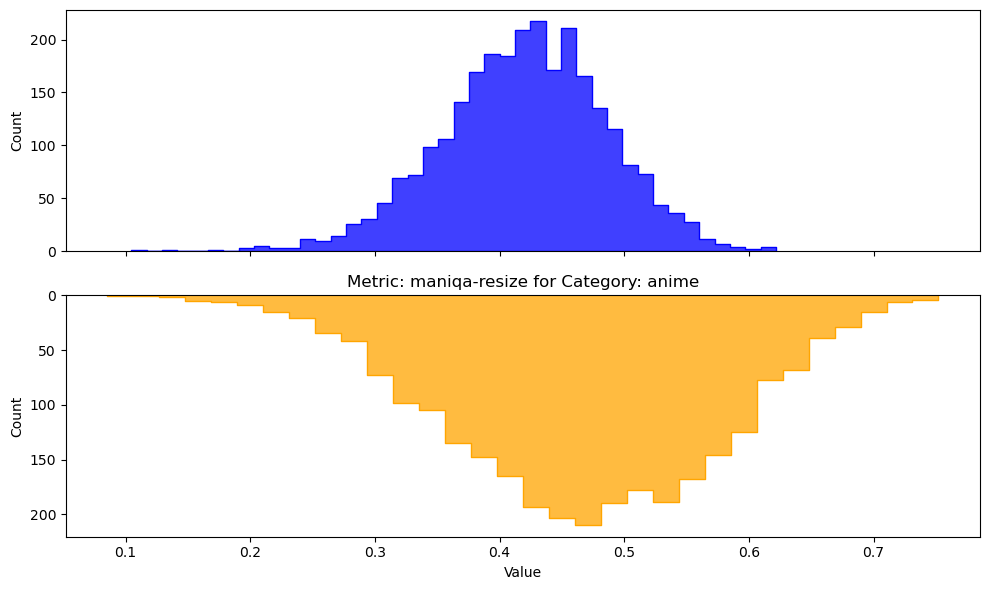

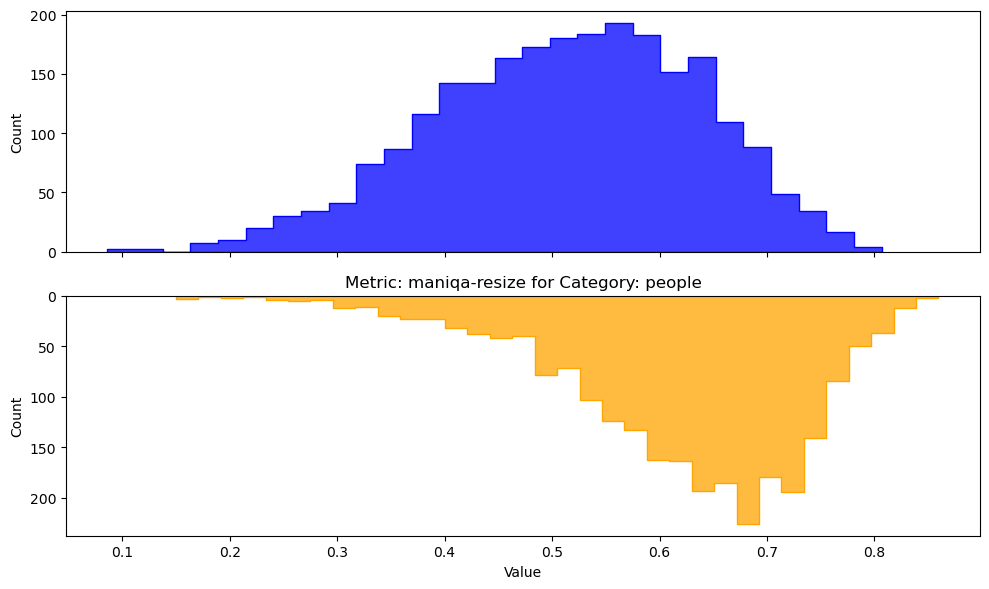

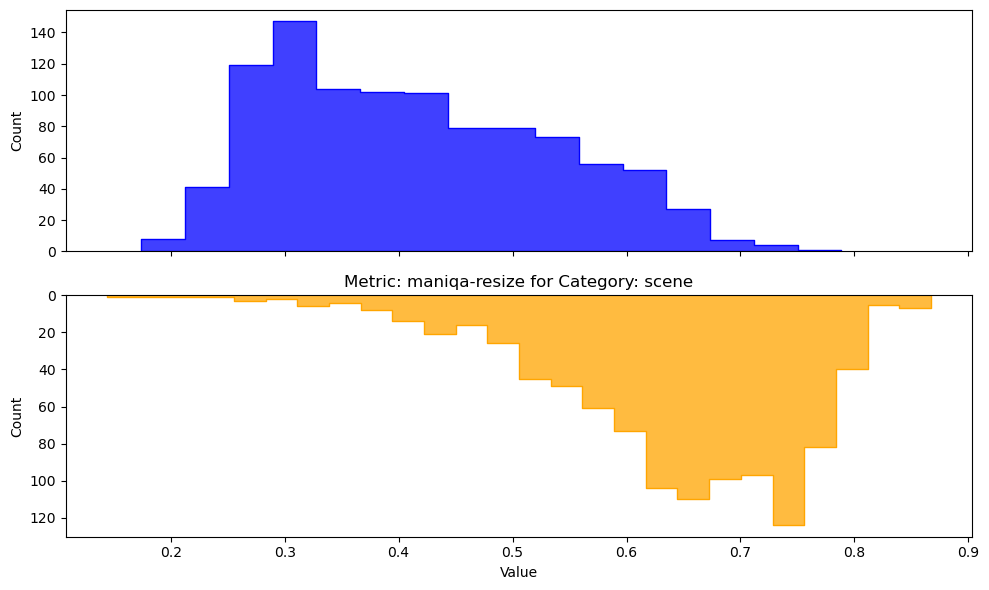

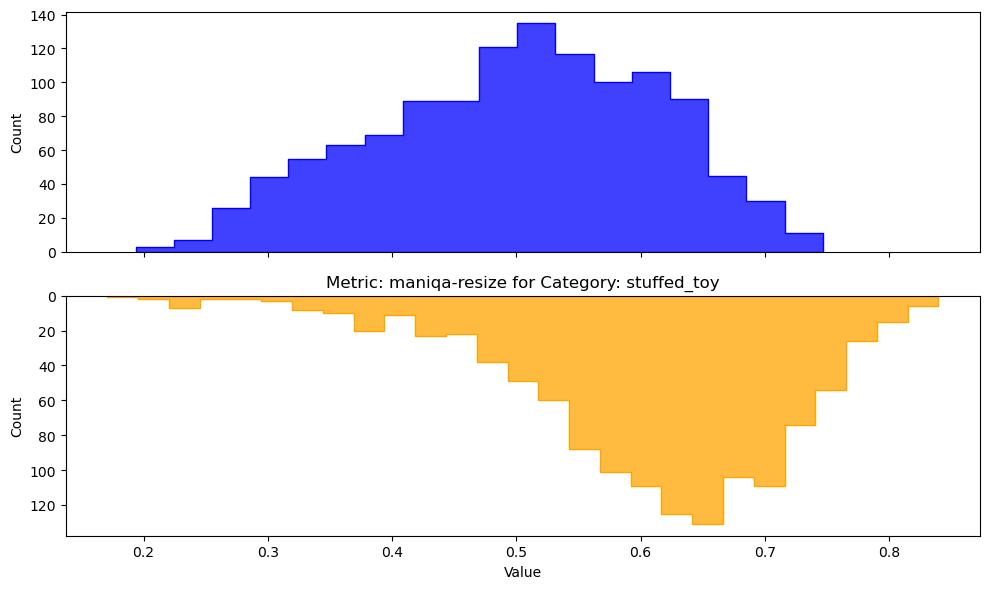

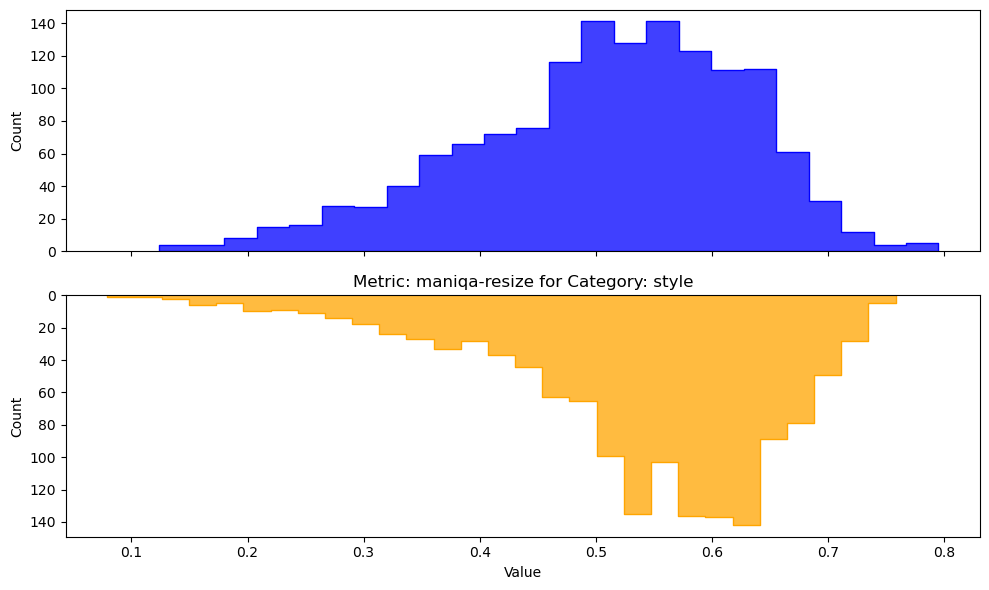

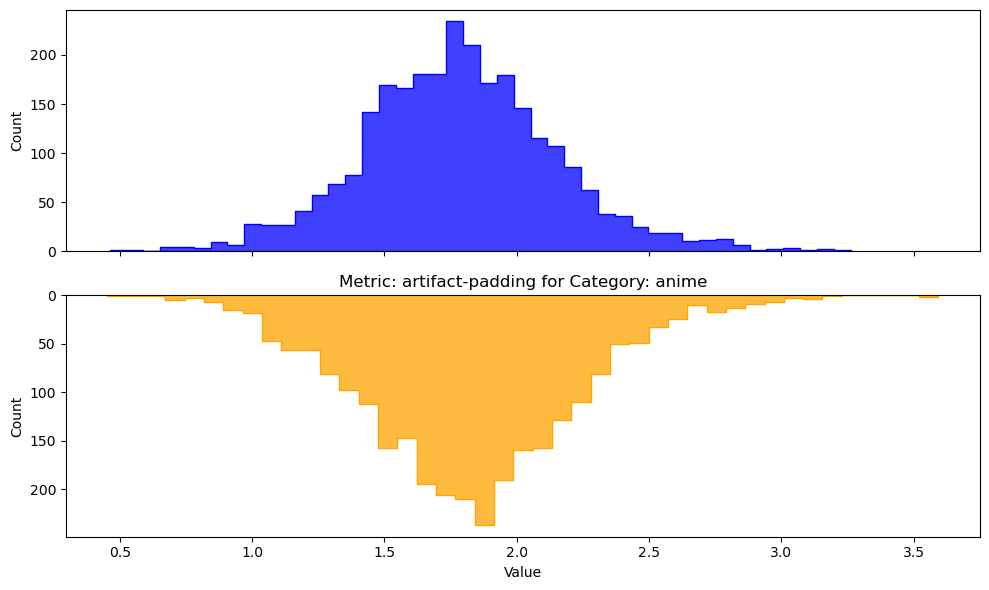

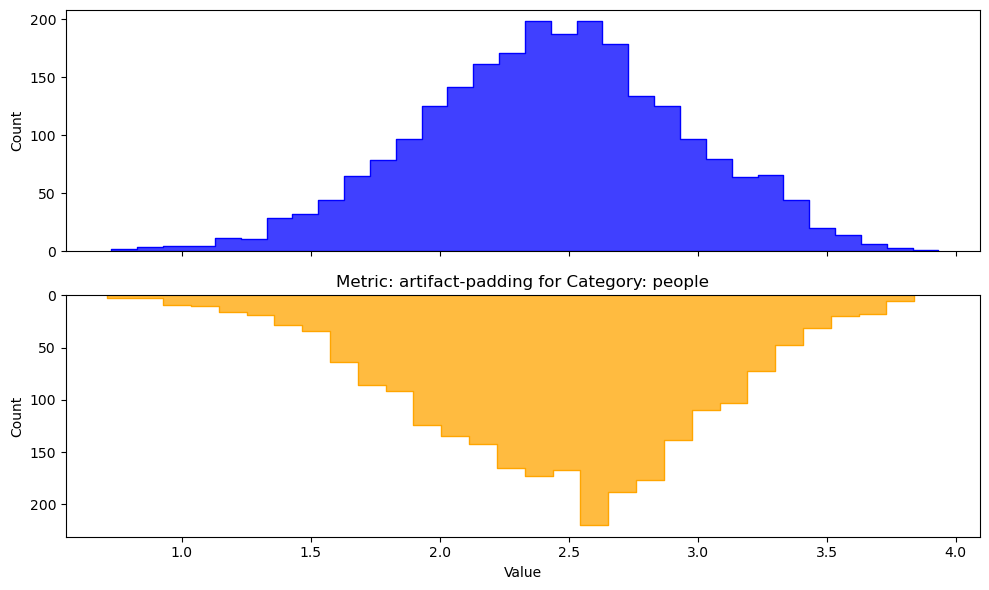

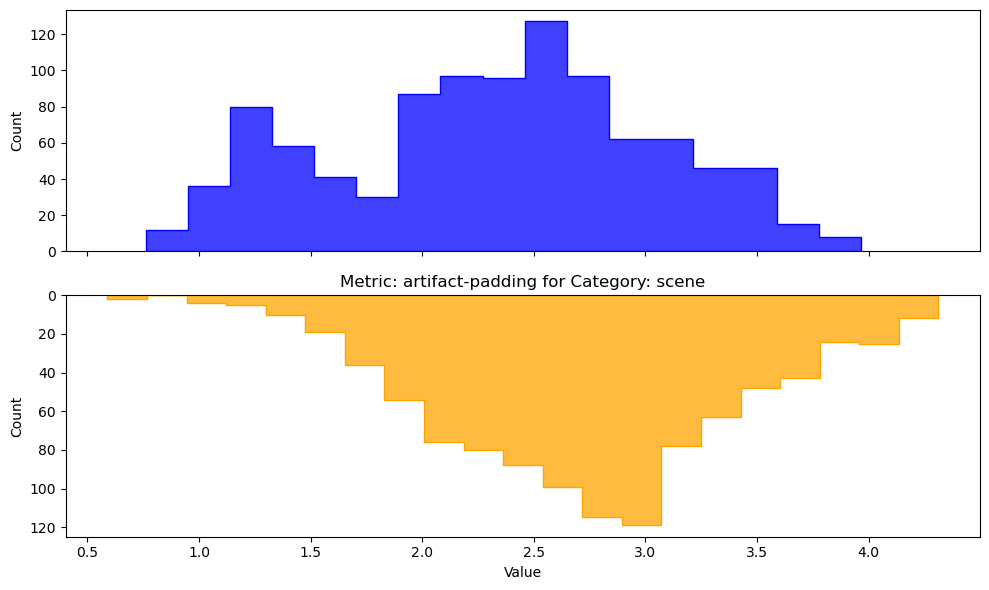

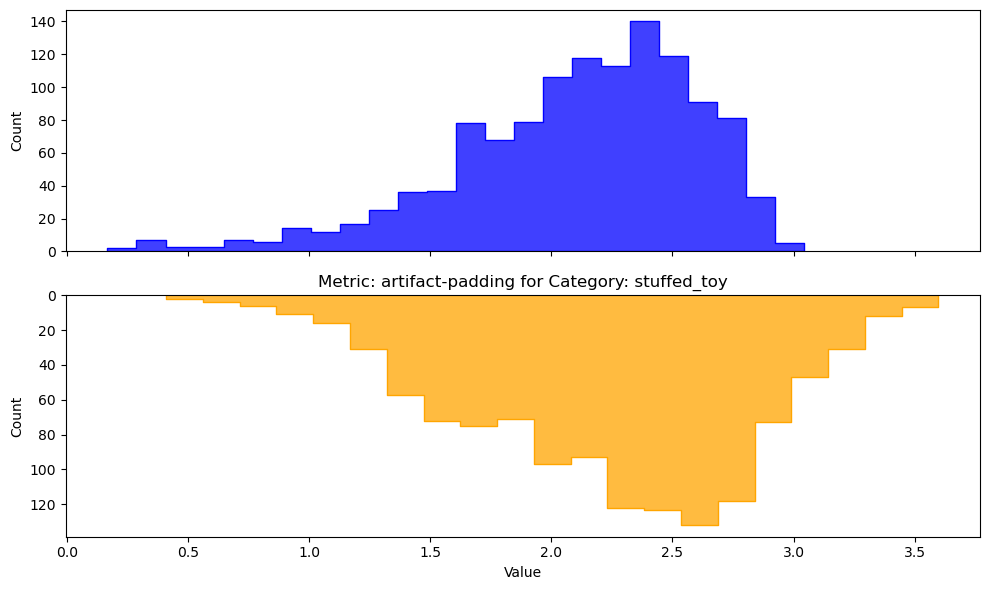

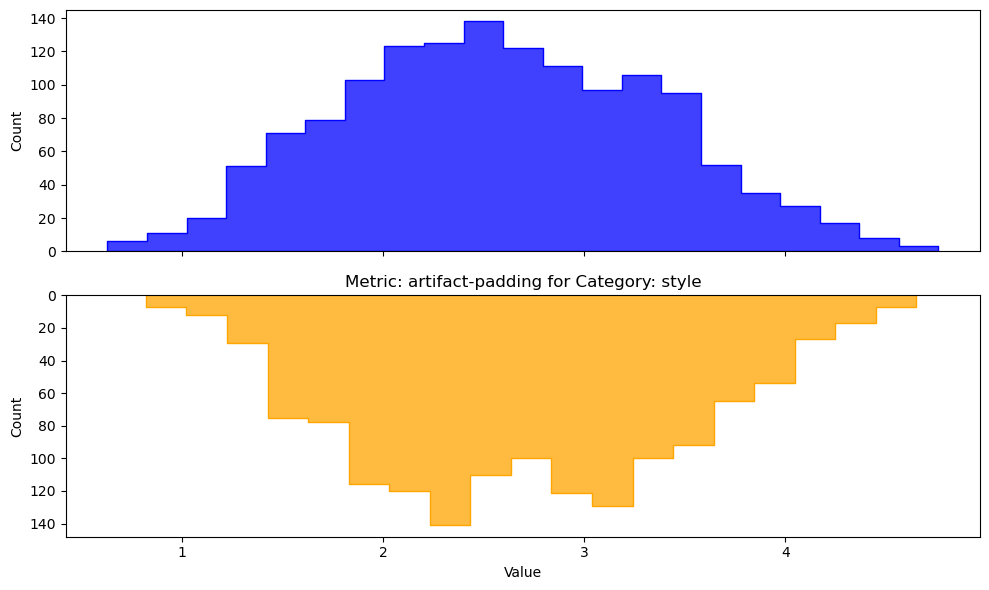

In [170]:
metrics = df_gen_lokr.columns[1:4]
categories = df_gen_lokr['category'].unique()

for metric in metrics:
    for category in categories:
        plot_mirrored_histogram_category(df_gen, df_gen_lokr, metric, category)
        plt.savefig(f'figures/db_lokr/{metric}-{category}.png')

In [226]:
metrics = df_gen_lokr.columns[1:4]
categories = df_gen_lokr['class'].unique()

for metric in metrics:
    for cls in categories:
        plot_mirrored_histogram_category(df, df_gen_lokr, metric, 'class', cls)
        plt.savefig(f'figures/lokr_classes/{metric}-f-{cls}.png')
        plt.close()

In [227]:
metrics = df_gen_lokr.columns[1:4]
categories = df_gen_lokr['class'].unique()

for metric in metrics:
    for cls in categories:
        plot_mirrored_histogram_category(df_gen, df_gen_lokr, metric, 'class', cls)
        plt.savefig(f'figures/db_lokr_classes/{metric}-f-{cls}.png')
        plt.close()

In [228]:
metrics = df_gen_lokr.columns[1:4]
categories = df_gen_lokr['class'].unique()

for metric in metrics:
    for cls in categories:
        plot_mirrored_histogram_category(df, df_gen, metric, 'class', cls)
        plt.savefig(f'figures/db_classes/{metric}-f-{cls}.png')
        plt.close()

In [231]:
df_styles = df[df['category']=='style']

/tmp/ipykernel_29438/3529520962.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_styles['dummy_index'] = range(len(df_styles))


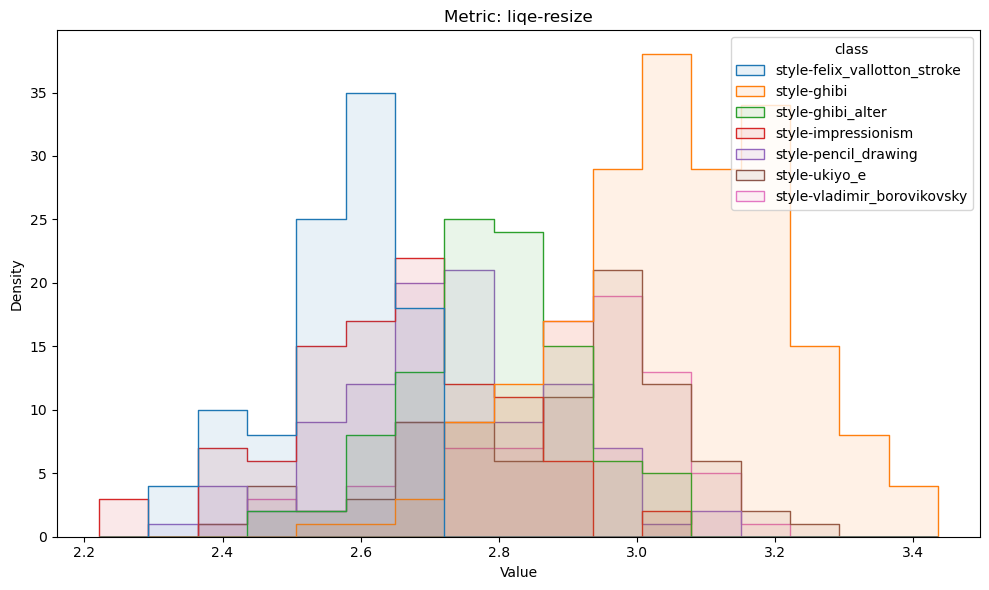

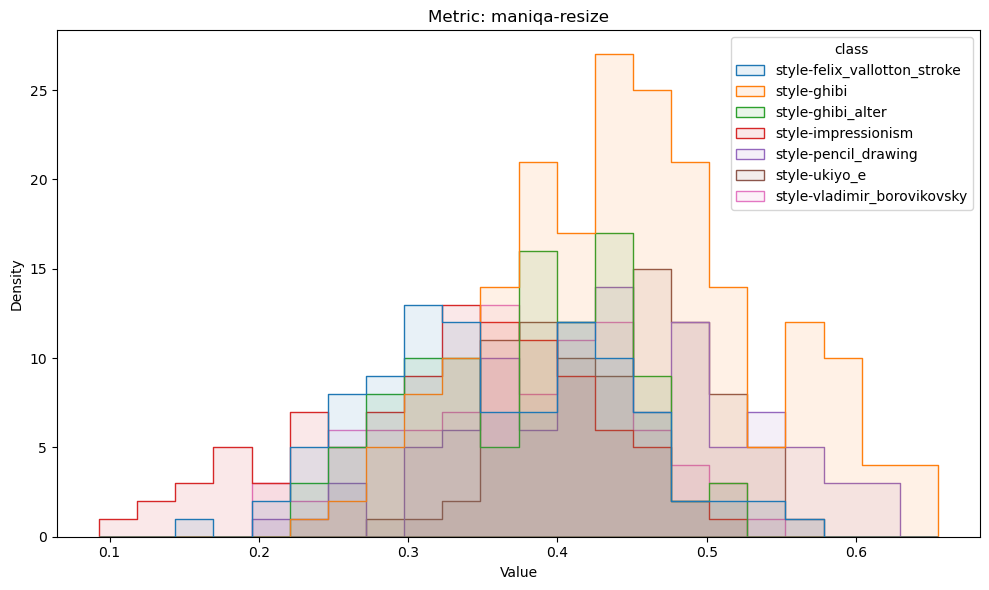

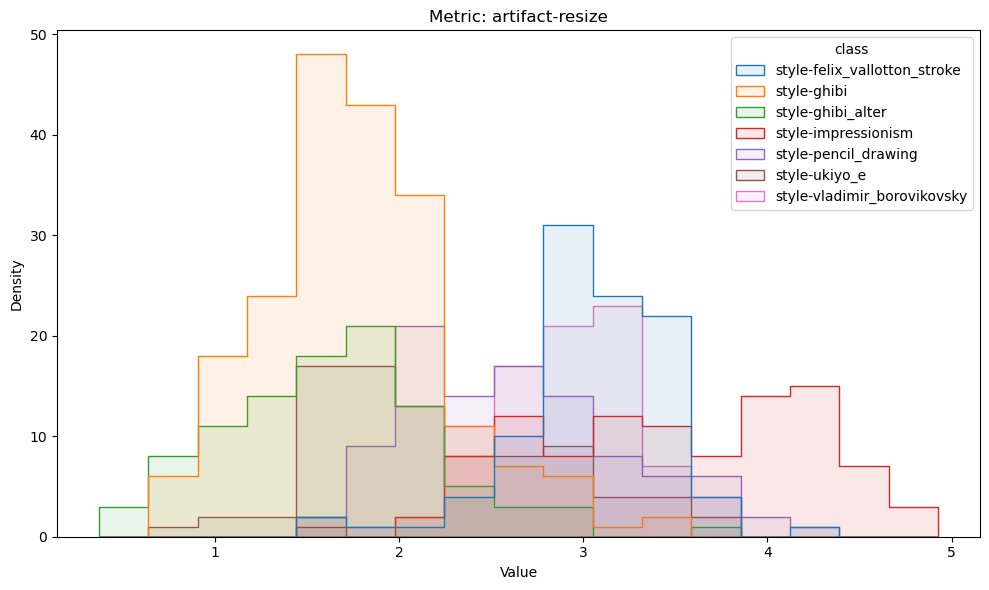

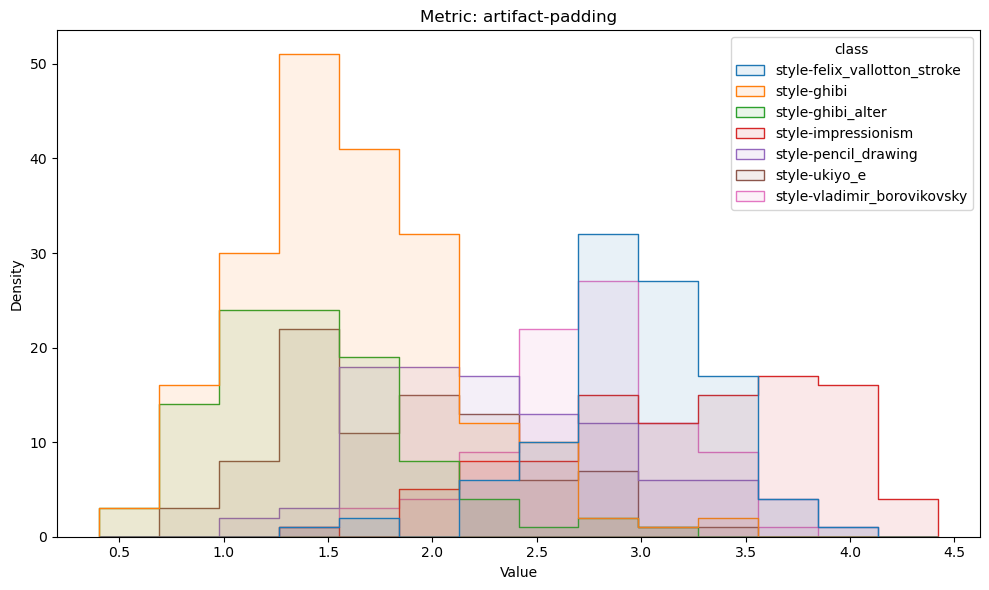

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

df_styles['dummy_index'] = range(len(df_styles))
metrics = df.columns[2:6]

for metric in metrics:

    metric_df = df_styles.pivot(index='dummy_index',
                                columns='class',
                                values=metric)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metric_df, element="step", common_norm=False, alpha=0.1)
    plt.title(f'Metric: {metric}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.savefig(f'figures/real-styles-{metric}.png')